# GEO-AI Cropland Mapping 
## Business Understanding

**Problem statement:** Delineate cropland extent (crop vs non-crop) for the target regions in the Geo-AI challenge. The output should be a per-location (pixel / parcel / point) cropland probability or label formatted for Zindi submissions.

**Objectives & success criteria**
- Primary: Maximize the competition score as defined by the organizers (use the official metric and submission format).  
- Secondary: Produce interpretable per-region performance reports and a reproducible inference pipeline.

**Constraints / risks**
- Limited labelled samples and regional variability (models must generalize across regions).  
- Risk of spatial leakage (nearby labelled points leaking into validation folds). Use spatially aware splits.  

**Relevant competition notes:** the task uses multi-temporal satellite imagery and a limited set of training samples — plan for weak labels, data augmentation and spatial CV. :contentReference[oaicite:1]{index=1}

In [1]:
# Cell 1: Environment Setup and Imports
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Standard data stack
import sys
import gc
import ctypes
import hashlib
from pathlib import Path
import os
import json
import pprint

import numpy as np
import pandas as pd

# Plotting / visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.05)

# Geospatial / raster
import geopandas as gpd
import rasterio
from pyproj import Transformer
import folium

# Machine learning — scikit-learn core
import sklearn
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import BallTree
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


# Extra ML libraries / optimizers
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna

# Imbalanced data handling
import imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# Deep learning (if used)
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Utilities often used in notebooks
from IPython.display import display

c:\Users\vihaa\anaconda3\envs\learn-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Understanding

**What’s in the dataset**
- Label files: coordinates + binary class (crop / non-crop) or similar label schema.  
- Satellite inputs: multi-temporal Sentinel-2 (optical bands), often provided as per-pixel time series or precomputed feature tiles.  
- Ancillary: cloud quality flags, acquisition dates, and possibly region IDs.

**Immediate checks to run (put these before heavy preprocessing)**
- Inspect label counts per class and per region (class balance).  
- Plot label spatial distribution to spot clustering / duplicates.  
- Check date coverage and number of observations per sample (temporal sparsity).  
- Confirm coordinate reference system and how labels align with imagery.

**Why this matters:** label imbalance, geographic clustering, or temporal gaps will determine the preprocessing choices (cloud masking, temporal aggregation) and CV strategy. :contentReference[oaicite:2]{index=2}

In [2]:
# Cell 2: Data Loading and Validation Pipeline
class DataLoader:
    def __init__(self, data_path="Data"):
        self.data_path = Path(data_path)
        self.training_samples = None
        self.sentinel1_df = None
        self.sentinel2_df = None
        self.test_df = None
        
    def load_training_samples(self):
        """Load and combine Fergana and Orenburg training samples"""
        try:
            fergana_gdf = gpd.read_file(self.data_path / "Fergana_training_samples.shp")
            orenburg_gdf = gpd.read_file(self.data_path / "Orenburg_training_samples.shp")
            
            # Add region identifier
            fergana_gdf['region'] = 'Fergana'
            orenburg_gdf['region'] = 'Orenburg'
            
            # Combine datasets
            self.training_samples = pd.concat([fergana_gdf, orenburg_gdf], ignore_index=True)
            
            print(f"Training samples loaded: {len(self.training_samples)} records")
            print(f"Fergana samples: {len(fergana_gdf)}")
            print(f"Orenburg samples: {len(orenburg_gdf)}")
            print(f"Cropland distribution:\n{self.training_samples['Cropland'].value_counts()}")
            
            return self.training_samples
            
        except Exception as e:
            print(f"Error loading training samples: {e}")
            return None
    
    def load_sentinel_data(self):
        """Load Sentinel-1 and Sentinel-2 data"""
        try:
            self.sentinel1_df = pd.read_csv(self.data_path / "Sentinel1.csv")
            self.sentinel2_df = pd.read_csv(self.data_path / "Sentinel2.csv")
            
            print(f"Sentinel-1 data loaded: {len(self.sentinel1_df)} records")
            print(f"Sentinel-2 data loaded: {len(self.sentinel2_df)} records")
            print(f"Sentinel-1 columns: {list(self.sentinel1_df.columns)}")
            print(f"Sentinel-2 columns: {list(self.sentinel2_df.columns)}")
            
            return self.sentinel1_df, self.sentinel2_df
            
        except Exception as e:
            print(f"Error loading Sentinel data: {e}")
            return None, None
    
    def load_test_data(self):
        """Load test data"""
        try:
            self.test_df = pd.read_csv(self.data_path / "Test.csv")
            print(f"Test data loaded: {len(self.test_df)} records")
            return self.test_df
        except Exception as e:
            print(f"Error loading test data: {e}")
            return None

# Initialize data loader
data_loader = DataLoader()
training_samples = data_loader.load_training_samples()
sentinel1_df, sentinel2_df = data_loader.load_sentinel_data()
test_df = data_loader.load_test_data()

Training samples loaded: 1000 records
Fergana samples: 500
Orenburg samples: 500
Cropland distribution:
Cropland
0    703
1    297
Name: count, dtype: int64
Sentinel-1 data loaded: 1752570 records
Sentinel-2 data loaded: 5610393 records
Sentinel-1 columns: ['ID', 'VH', 'VV', 'date', 'orbit', 'polarization', 'rel_orbit', 'translated_lat', 'translated_lon']
Sentinel-2 columns: ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'ID', 'cloud_pct', 'date', 'solar_azimuth', 'solar_zenith', 'translated_lat', 'translated_lon']
Test data loaded: 600 records


## Data Preparation (plan and checklist)

**High-level plan**
1. Quality filtering: apply cloud and QA masks; drop very noisy observations.  
2. Temporal normalization: align to a consistent cadence (e.g. monthly / dekadal) or aggregate using stats + phenology features.  
3. Feature construction: vegetation indices (NDVI, EVI), temporal stats (median, max, std, percentiles), change metrics, seasonal features.  
4. Spatial join: merge labels with preprocessed pixel / patch features — ensure no coordinate misalignment.  
5. Train/validation split: use spatial (region / block) or leave-locations-out CV to avoid leakage.  
6. Save intermediate caches and metadata (date ranges, counts) for reproducibility.

**Checklist of implementation details to verify in code**
- consistent dtype and missing value handling for all bands/indices;  
- reproducible seed and deterministic processing where possible;  
- caching strategy to avoid recomputing heavy I/O steps;  
- verify resulting feature shapes match model expectations (especially for DL).


In [3]:
# Cell 3: Fast Memory-Optimized Preprocessing (no GEE) – with indices, caching, quality summary, cleanup

# Optional toggles
FAST_OPTS = {
    'compute_indices': True,
    'use_cache': True,
    'threshold_candidates_deg': [0.005, 0.01, 0.02, 0.05, 0.1],
    'adaptive_percentile': 90,
    'adaptive_cap_deg': 0.1
}

def cleanup_memory():
    gc.collect()
    try:
        import ctypes
        ctypes.windll.kernel32.SetProcessWorkingSetSize(-1, -1, -1)
    except Exception:
        pass

def downcast_floats(df):
    num_cols = df.select_dtypes(include=['float64','float32']).columns
    if len(num_cols):
        df[num_cols] = df[num_cols].astype('float32')
    return df

_cache_dir = Path('cache')
_cache_dir.mkdir(exist_ok=True)

def _hash_df_signature(df):
    sig = f"{len(df)}|{','.join(sorted(df.columns))}"
    return hashlib.md5(sig.encode()).hexdigest()[:10]

def cache_agg(name, build_fn):
    # Read cached parquet if available; else compute and write parquet (fallback to CSV)
    path_parquet = _cache_dir / f"{name}.parquet"
    path_csv = _cache_dir / f"{name}.csv"
    if FAST_OPTS['use_cache']:
        if path_parquet.exists():
            try:
                return pd.read_parquet(path_parquet)
            except Exception:
                pass
        if path_csv.exists():
            try:
                return pd.read_csv(path_csv)
            except Exception:
                pass
    out = build_fn()
    if FAST_OPTS['use_cache']:
        try:
            out.to_parquet(path_parquet, index=False)
        except Exception:
            try:
                out.to_csv(path_csv, index=False)
            except Exception:
                pass
    return out

class FastDataPreprocessor:
    def __init__(self, chunk_size=100_000):
        self.chunk_size = int(chunk_size)

    def _sanitize_training(self, df):
        df = df.copy()
        # Ensure lat/lon present
        if 'translated_lat' not in df.columns or 'translated_lon' not in df.columns:
            if 'geometry' in df.columns:
                df['translated_lon'] = df.geometry.x
                df['translated_lat'] = df.geometry.y
            else:
                raise ValueError("Training data needs 'translated_lat'/'translated_lon' or 'geometry'.")
        df = df.dropna(subset=['translated_lat','translated_lon'])
        df = df[(df['translated_lat'].between(-90, 90)) & (df['translated_lon'].between(-180, 180))]
        df = df.drop_duplicates(subset=['translated_lat','translated_lon'])
        return df

    def _ensure_training_columns(self, training_df):
        df = self._sanitize_training(training_df)
        if 'latitude' not in df.columns:
            df['latitude'] = df['translated_lat']
        if 'longitude' not in df.columns:
            df['longitude'] = df['translated_lon']
        if 'ID' not in df.columns:
            df['ID'] = np.arange(len(df)).astype(str)
        df['ID'] = df['ID'].astype(str)
        cols = ['ID','Cropland','region','longitude','latitude']
        if 'geometry' in df.columns:
            cols.append('geometry')
        return df[cols]

    def _aggregate_satellite_data_efficiently(self, satellite_df, data_type, agg_config):
        chunk_size = self.chunk_size
        total = len(satellite_df)
        chunks = []
        for start in range(0, total, chunk_size):
            end = min(start + chunk_size, total)
            chunk = satellite_df.iloc[start:end].copy()
            if 'translated_lat' not in chunk.columns or 'translated_lon' not in chunk.columns:
                raise ValueError(f"{data_type} missing 'translated_lat'/'translated_lon'")
            present_agg = {col: func for col, func in agg_config.items() if col in chunk.columns}
            if present_agg:
                grp = chunk.groupby(['translated_lat','translated_lon']).agg(present_agg).reset_index()
            else:
                grp = chunk[['translated_lat','translated_lon']].drop_duplicates().reset_index(drop=True)
            chunks.append(grp)
            del chunk
            cleanup_memory()
        if not chunks:
            return pd.DataFrame(columns=['translated_lat','translated_lon'])
        combined = pd.concat(chunks, ignore_index=True)
        del chunks
        cleanup_memory()

        numeric_cols, string_cols = [], []
        for col in combined.columns:
            if col not in ['translated_lat','translated_lon']:
                (string_cols if combined[col].dtype in ['object','string'] else numeric_cols).append(col)
        final_agg = {col:'mean' for col in numeric_cols}
        final_agg.update({col:'first' for col in string_cols})
        if final_agg:
            out = combined.groupby(['translated_lat','translated_lon']).agg(final_agg).reset_index()
        else:
            out = combined[['translated_lat','translated_lon']].drop_duplicates().reset_index(drop=True)
        del combined
        cleanup_memory()
        return out

    def _choose_threshold_deg(self, train_deg, sat_deg):
        if len(sat_deg) == 0:
            return 0.0
        tree = BallTree(np.radians(sat_deg), metric='haversine')
        dists_rad, _ = tree.query(np.radians(train_deg), k=1)
        dists_deg = dists_rad.flatten() * 180/np.pi
        best = FAST_OPTS['threshold_candidates_deg'][1]  # default 0.01°
        best_hits = 0
        for thr in FAST_OPTS['threshold_candidates_deg']:
            hits = (dists_deg <= thr).sum()
            if hits > best_hits:
                best_hits, best = hits, thr
        if best_hits < max(1, int(0.5*len(train_deg))):
            best = min(np.percentile(dists_deg, FAST_OPTS['adaptive_percentile']), FAST_OPTS['adaptive_cap_deg'])
        return float(best)

    def _match_and_attach(self, training_df, sat_df, prefix):
        out = training_df.copy()
        if len(sat_df) == 0:
            out[f'{prefix}_match_distance'] = np.nan
            return out
        train_pts = training_df[['longitude','latitude']].to_numpy()
        sat_pts = sat_df[['translated_lon','translated_lat']].to_numpy()
        thr_deg = self._choose_threshold_deg(train_pts, sat_pts)

        tree = BallTree(np.radians(sat_pts), metric='haversine')
        dists_rad, idx = tree.query(np.radians(train_pts), k=1)
        dists_deg = (dists_rad.flatten() * 180/np.pi)
        valid = dists_deg <= thr_deg
        idx = idx.flatten()

        attach_cols = [c for c in sat_df.columns if c not in ['translated_lat','translated_lon']]
        for c in attach_cols:
            out[f'{prefix}_{c}'] = np.nan
        out[f'{prefix}_match_distance'] = np.nan

        if valid.any():
            sat_valid = sat_df.iloc[idx[valid]][attach_cols].reset_index(drop=True)
            out_valid_idx = np.where(valid)[0]
            for c in attach_cols:
                out.loc[out_valid_idx, f'{prefix}_{c}'] = sat_valid[c].to_numpy()
            out.loc[out_valid_idx, f'{prefix}_match_distance'] = dists_deg[valid]
        return out

    def _precision_key_fallback_fill(self, out, train, s1_agg, s2_agg, precision=2):
        # Build precision keys
        t = train[['ID','longitude','latitude']].copy()
        t['lat_k'] = t['latitude'].round(precision)
        t['lon_k'] = t['longitude'].round(precision)
        t['key'] = t['lat_k'].astype(str) + '_' + t['lon_k'].astype(str)

        for df, pref in [(s1_agg, 'S1'), (s2_agg, 'S2')]:
            if len(df) == 0:
                continue
            df_k = df.copy()
            df_k['lat_k'] = df_k['translated_lat'].round(precision)
            df_k['lon_k'] = df_k['translated_lon'].round(precision)
            df_k['key'] = df_k['lat_k'].astype(str) + '_' + df_k['lon_k'].astype(str)
            # Mean all numeric columns except coords
            num_cols = df_k.select_dtypes(include=[np.number]).columns.tolist()
            num_cols = [c for c in num_cols if c not in ['translated_lat','translated_lon','lat_k','lon_k']]
            if num_cols:
                g = df_k.groupby('key')[num_cols].mean().reset_index()
            else:
                g = df_k[['key']].drop_duplicates().copy()
            # Prefix
            g = g.rename(columns={c: f'{pref}_{c}' for c in g.columns if c != 'key'})
            t = t.merge(g, on='key', how='left')

        # Merge fallback features into out by ID, filling NaNs only
        fb_cols = [c for c in t.columns if c.startswith('S1_') or c.startswith('S2_')]
        if fb_cols:
            merged = out.merge(t[['ID'] + fb_cols], on='ID', how='left', suffixes=('','_fb'))
            for c in fb_cols:
                base = c if c in out.columns else None
                fb = f"{c}_fb"
                if base:
                    merged[base] = merged[base].where(~merged[base].isna(), merged[fb])
                else:
                    merged[c] = merged[fb]
                merged.drop(columns=[fb], inplace=True)
            return merged
        return out

    def preprocess_fast(self, training_samples, sentinel1_df, sentinel2_df):
        print("Fast memory-optimized preprocessing (no GEE)")
        # 1) Prepare training
        train = self._ensure_training_columns(training_samples)
        print(f"   Training points: {len(train)}")

        # 2) Aggregate Sentinel-1 (cache-enabled)
        s1_agg_cfg = {'VH': 'mean', 'VV': 'mean'}
        print(f"   Aggregating Sentinel-1 ({len(sentinel1_df):,} rows)...")
        s1_cache_key = f"s1_agg_{_hash_df_signature(sentinel1_df)}"
        s1_agg = cache_agg(s1_cache_key, lambda: self._aggregate_satellite_data_efficiently(sentinel1_df, 'S1', s1_agg_cfg))
        print(f"     → {len(s1_agg):,} unique S1 locations")

        # 3) Aggregate Sentinel-2 (cache-enabled)
        s2_numeric = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','cloud_pct','solar_azimuth','solar_zenith']
        s2_agg_cfg = {c:'mean' for c in s2_numeric}
        print(f"   Aggregating Sentinel-2 ({len(sentinel2_df):,} rows)...")
        s2_cache_key = f"s2_agg_{_hash_df_signature(sentinel2_df)}"
        s2_agg = cache_agg(s2_cache_key, lambda: self._aggregate_satellite_data_efficiently(sentinel2_df, 'S2', s2_agg_cfg))
        print(f"     → {len(s2_agg):,} unique S2 locations")

        cleanup_memory()

        # 4) Match and attach S1
        print("   Matching Sentinel-1...")
        s1_matched = self._match_and_attach(train, s1_agg, 'S1')

        # 5) Match and attach S2
        print("   Matching Sentinel-2...")
        s2_matched = self._match_and_attach(train, s2_agg, 'S2')

        # 6) Combine
        print("   Combining matched features...")
        base_cols = [c for c in ['ID','Cropland','region','longitude','latitude','geometry'] if c in training_samples.columns or c in train.columns]
        out = train[base_cols].copy()
        for c in s1_matched.columns:
            if c.startswith('S1_'):
                out[c] = s1_matched[c].values
        for c in s2_matched.columns:
            if c.startswith('S2_'):
                out[c] = s2_matched[c].values

        # 7) Coverage check; fallback precision-merge fill if low
        s1_cols = [c for c in out.columns if c.startswith('S1_') and not c.endswith('_match_distance')]
        s2_cols = [c for c in out.columns if c.startswith('S2_') and not c.endswith('_match_distance')]
        s1_cov = (out[s1_cols[0]].notna().mean() if s1_cols else 0.0)
        s2_cov = (out[s2_cols[0]].notna().mean() if s2_cols else 0.0)
        if min(s1_cov, s2_cov) < 0.30:
            print("   Low coverage detected; applying precision-key fallback fill (2 d.p.)...")
            out = self._precision_key_fallback_fill(out, train, s1_agg, s2_agg, precision=2)

        # 8) Derived indices (fast)
        if FAST_OPTS['compute_indices']:
            if {'S2_B8','S2_B4'}.issubset(out.columns):
                out['NDVI_from_S2'] = (out['S2_B8'] - out['S2_B4']) / (out['S2_B8'] + out['S2_B4'])
            if {'S2_B3','S2_B8'}.issubset(out.columns):
                out['NDWI_from_S2'] = (out['S2_B3'] - out['S2_B8']) / (out['S2_B3'] + out['S2_B8'])
            if {'S1_VH','S1_VV'}.issubset(out.columns):
                out['VH_VV_ratio_from_S1'] = out['S1_VH'] / out['S1_VV']
            if {'S2_B8','S2_B4','S2_B2'}.issubset(out.columns):
                out['EVI_from_S2'] = 2.5 * ((out['S2_B8'] - out['S2_B4']) / (out['S2_B8'] + 6*out['S2_B4'] - 7.5*out['S2_B2'] + 1))
            if {'S2_B8','S2_B4'}.issubset(out.columns):
                L = 0.5
                out['SAVI_from_S2'] = (1 + L) * (out['S2_B8'] - out['S2_B4']) / (out['S2_B8'] + out['S2_B4'] + L)
                out['MSAVI_from_S2'] = (2*out['S2_B8'] + 1 - np.sqrt((2*out['S2_B8'] + 1)**2 - 8*(out['S2_B8'] - out['S2_B4']))) / 2
            if {'S2_B8','S2_B5'}.issubset(out.columns):
                out['RECI_from_S2'] = (out['S2_B8'] / out['S2_B5']) - 1
            if {'S2_B8','S2_B3'}.issubset(out.columns):
                out['GCI_from_S2'] = (out['S2_B8'] / out['S2_B3']) - 1

        # 9) Downcast floats and summarize quality
        out = downcast_floats(out)

        print("Fast preprocessing complete")
        if s1_cols:
            print(f"   S1 coverage: {out[s1_cols[0]].notna().sum()}/{len(out)} ({out[s1_cols[0]].notna().mean()*100:.1f}%)")
        if s2_cols:
            print(f"   S2 coverage: {out[s2_cols[0]].notna().sum()}/{len(out)} ({out[s2_cols[0]].notna().mean()*100:.1f}%)")
        for c in [col for col in out.columns if col.endswith('_match_distance')]:
            m = out[c].dropna()
            if not m.empty:
                print(f"   {c}: min={m.min():.4f}°, mean={m.mean():.4f}°, p90={m.quantile(0.9):.4f}°")
        print(f"   Output shape: {out.shape}")

        cleanup_memory()
        return out

# Execute fast preprocessing (no GEE). Produces `merged_data` for downstream compatibility.
print("Starting fast preprocessing and merging (no GEE)...")
fast_preprocessor = FastDataPreprocessor(chunk_size=100_000)
fast_merged = fast_preprocessor.preprocess_fast(training_samples, sentinel1_df, sentinel2_df)

if fast_merged is not None and len(fast_merged) > 0:
    merged_data = fast_merged
    print(f"\n✓ Fast preprocessing completed successfully!")
    print(f"Final dataset ready for modeling: {merged_data.shape}")
else:
    print("Fast preprocessing failed.")

Starting fast preprocessing and merging (no GEE)...
Fast memory-optimized preprocessing (no GEE)
   Training points: 1000
   Aggregating Sentinel-1 (1,752,570 rows)...
     → 1,752,570 unique S1 locations
   Aggregating Sentinel-2 (5,610,393 rows)...
     → 27,923 unique S2 locations
   Matching Sentinel-1...
   Matching Sentinel-2...
   Combining matched features...
Fast preprocessing complete
   S1 coverage: 817/1000 (81.7%)
   S2 coverage: 816/1000 (81.6%)
   S1_match_distance: min=0.0014°, mean=0.0393°, p90=0.0708°
   S2_match_distance: min=0.0015°, mean=0.0392°, p90=0.0706°
   Output shape: (1000, 31)

✓ Fast preprocessing completed successfully!
Final dataset ready for modeling: (1000, 31)


## Exploratory Data Analysis (EDA)

**Plots and tables to generate**
- Class distribution per region (bar chart).  
- Map of labelled points colored by class (spatial view).  
- Time series of NDVI / key indices for random crop vs non-crop samples (overlay).  
- Histograms / density plots of key indices (NDVI, EVI, red-edge) separated by class.  
- Observation counts per sample (how many time points each training sample has).

**Interpretation prompts (write these as short notes after each plot)**
- Do classes separate cleanly on mean / max NDVI? If not — consider additional spectral features.  
- Are labelled points spatially clustered (risk of spatial overfitting)? If yes, use block CV.  
- Are there severe temporal gaps or large regions with no cloudy-free pixels? Consider temporal imputation or synthetic augmentation.


Using merged_data from preprocessing...
Starting Exploratory Data Analysis...
Dataset shape: (1000, 31)
Feature columns identified: 23
Sample features: ['S1_VH', 'S1_VV', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A']
DATASET OVERVIEW
Total samples: 1,000
Total features: 23
Approx. memory usage: 0.23 MB

Cropland distribution:
  Class 0: 703 samples (70.3%)
  Class 1: 297 samples (29.7%)

Regional distribution:
  Fergana: 500 samples (50.0%)
  Orenburg: 500 samples (50.0%)

Sentinel-1 coverage: 817/1000 (81.7%)
Sentinel-2 coverage: 816/1000 (81.6%)
S1_match_distance: min=0.0014°, mean=0.0393°, p90=0.0708°
S2_match_distance: min=0.0015°, mean=0.0392°, p90=0.0706°

Feature statistics:
  Numeric features: 23
  Missing values (total): 4,229
  Complete rows: 816

Generating visualizations...


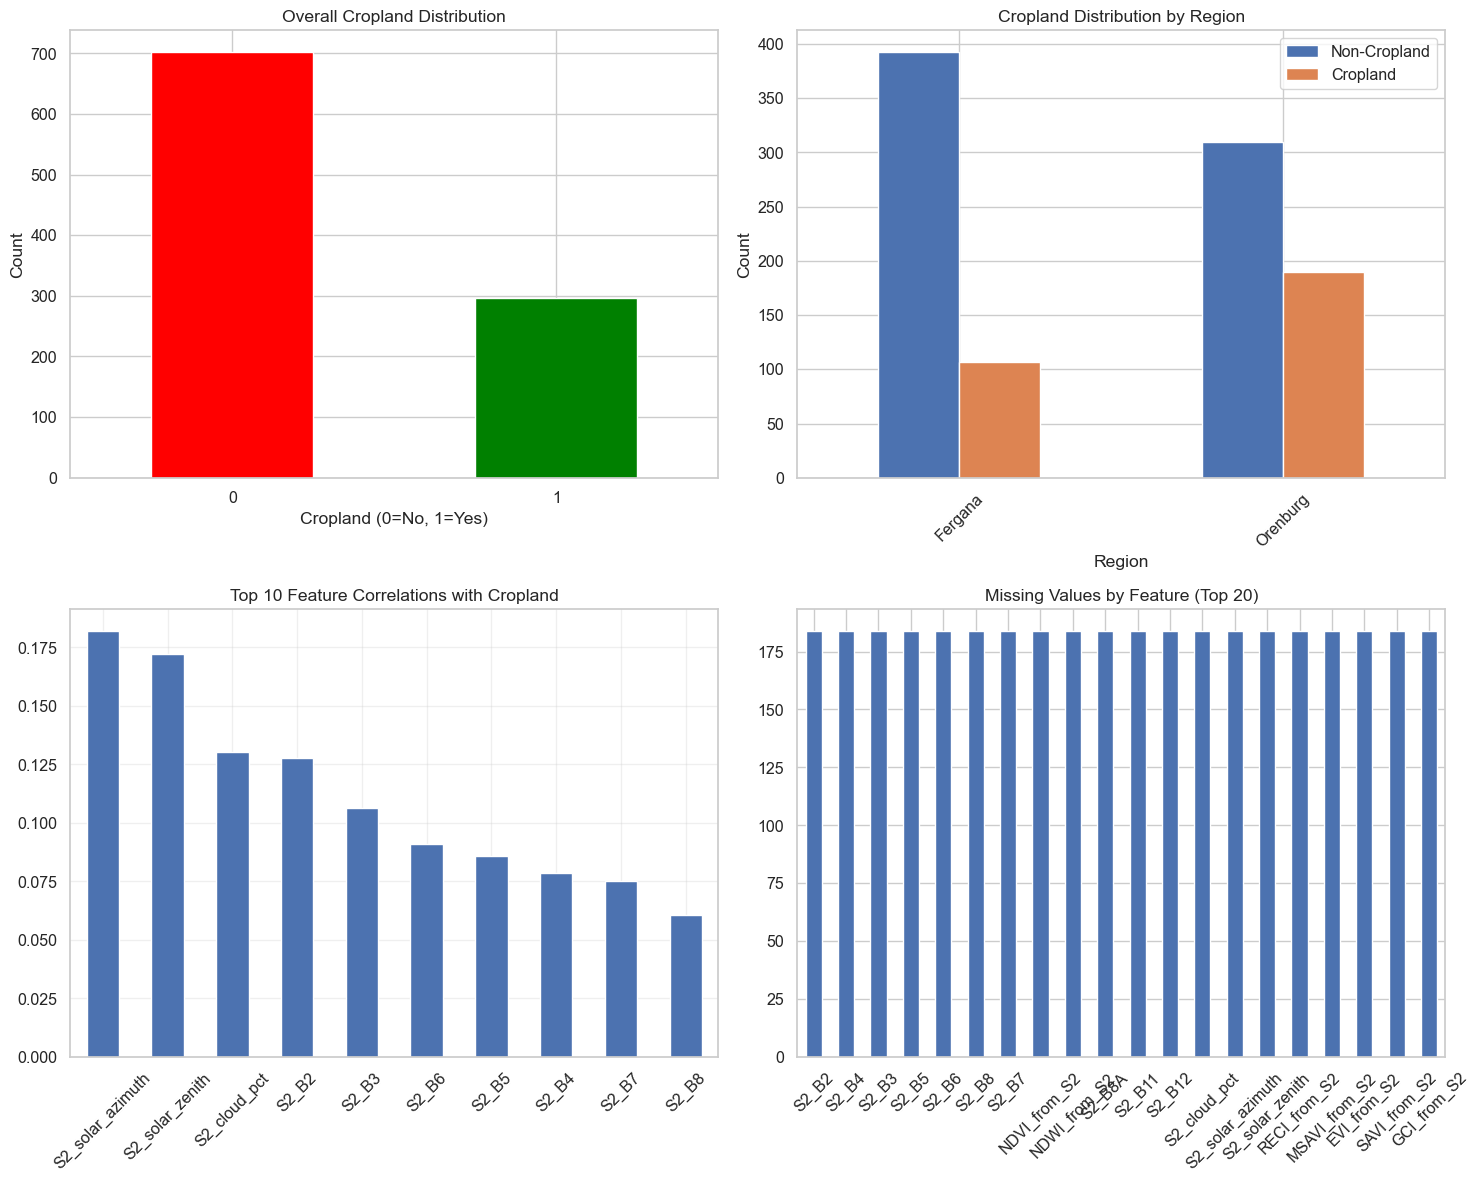

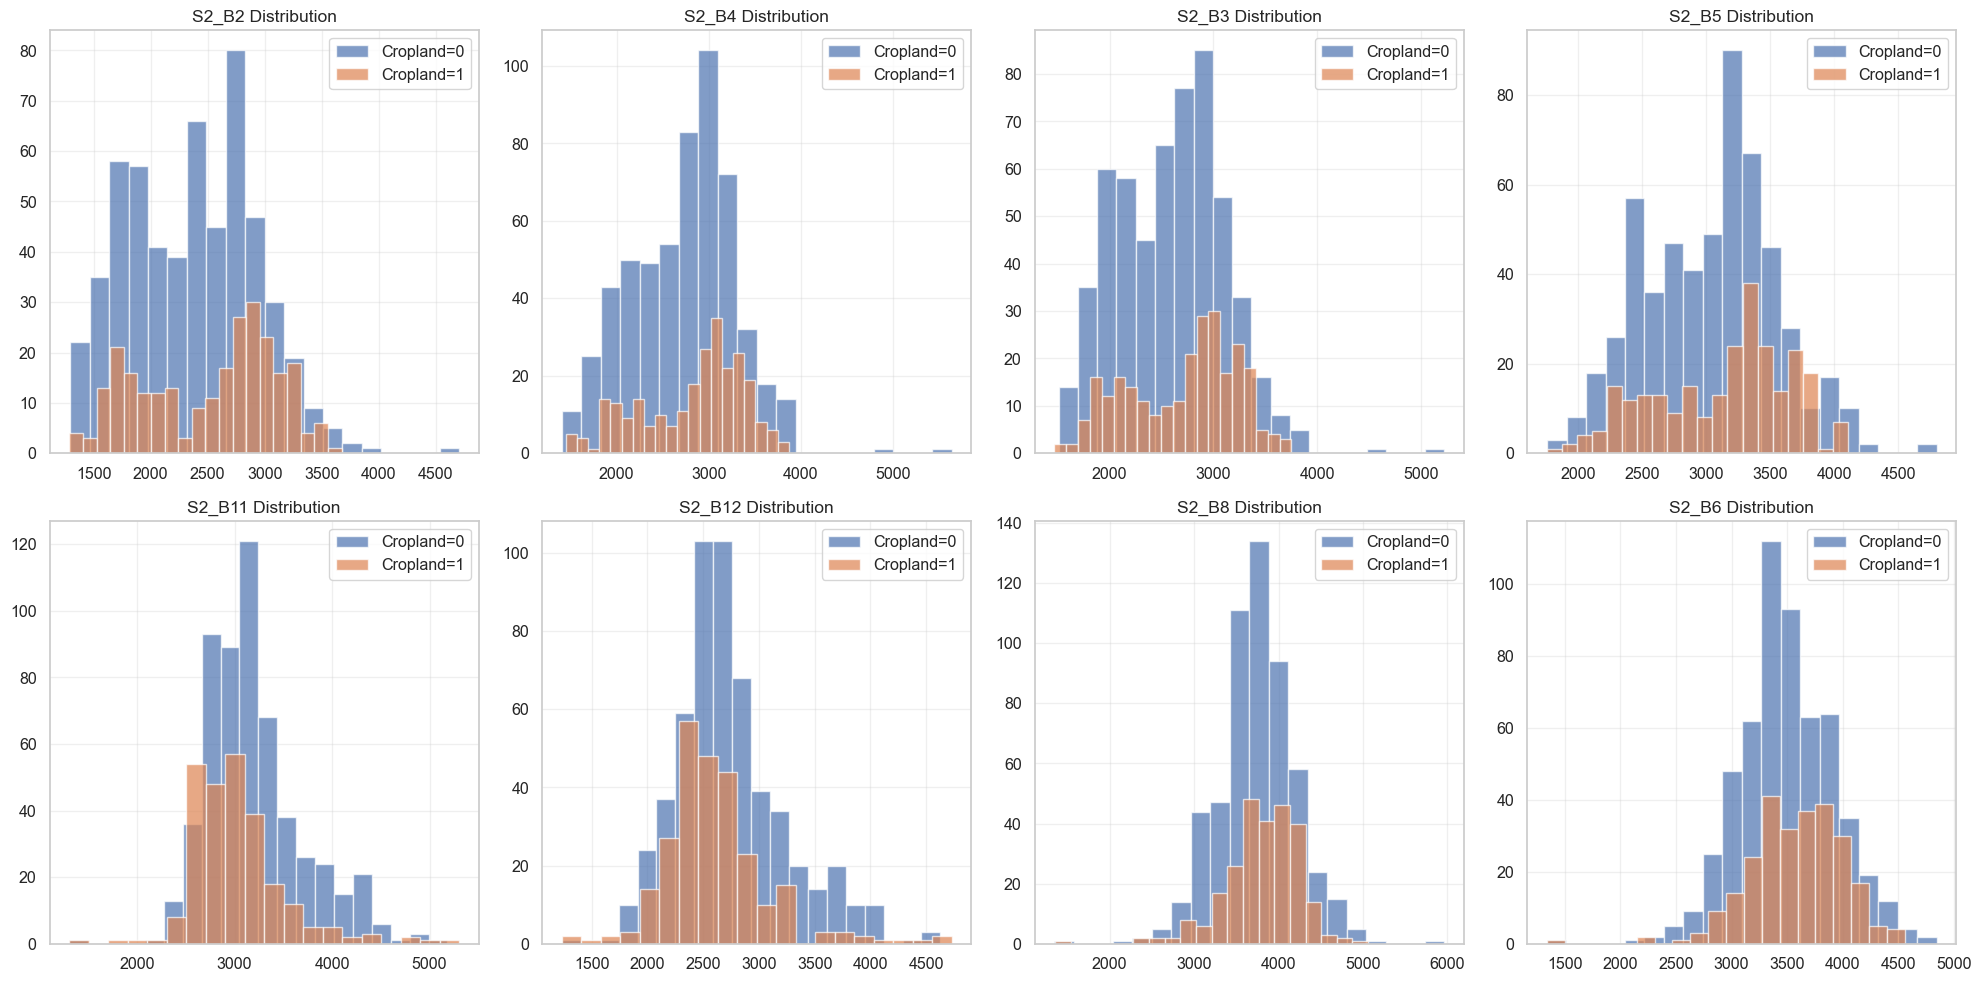

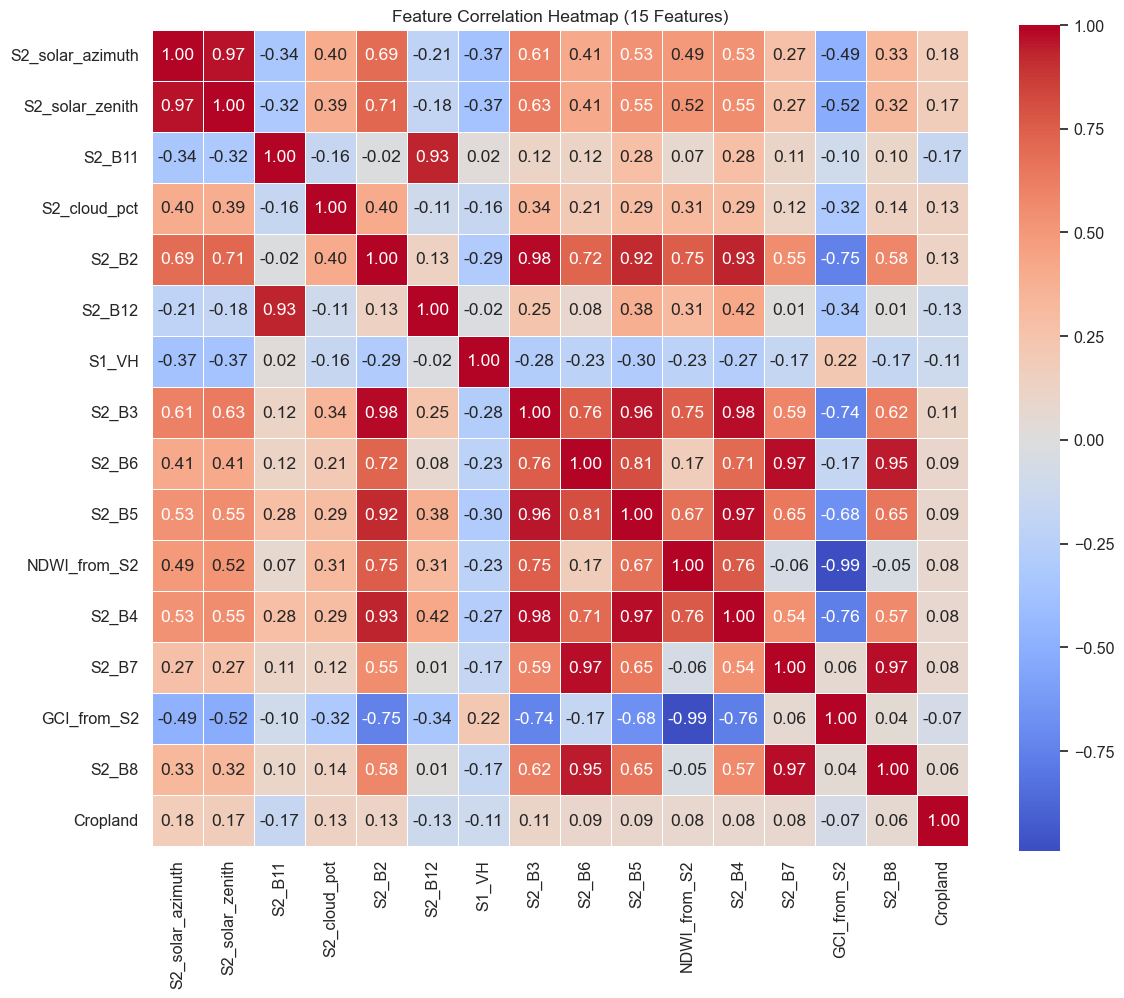

EDA completed successfully!


In [4]:
# Cell 4: Exploratory Data Analysis and Visualization (aligned with fast preprocessing)

# Identify feature columns, excluding targets/ids/coords/keys/distances
def identify_feature_columns(data):
    exclude_cols = [
        'Cropland', 'region', 'ID',
        'location_key', 'location_key_p0', 'location_key_p1', 'location_key_p2',
        'geometry', 'match_distance_km'
    ]
    exclude_patterns = ['lat', 'lon', 'key', 'geometry', 'distance']
    feature_columns = []
    for col in data.columns:
        if col in exclude_cols:
            continue
        if any(pattern in col.lower() for pattern in exclude_patterns):
            continue
        if pd.api.types.is_numeric_dtype(data[col]):
            feature_columns.append(col)
    return feature_columns

class EDAVisualizer:
    def __init__(self, data):
        self.data = data.copy()
        # Ensure Cropland numeric if present
        if 'Cropland' in self.data.columns and not pd.api.types.is_numeric_dtype(self.data['Cropland']):
            with pd.option_context('mode.chained_assignment', None):
                self.data['Cropland'] = pd.to_numeric(self.data['Cropland'], errors='coerce').fillna(0).astype(int)

        self.feature_columns = identify_feature_columns(self.data)
        self.s1_cols = [c for c in self.data.columns if c.startswith('S1_') and not c.endswith('_match_distance')]
        self.s2_cols = [c for c in self.data.columns if c.startswith('S2_') and not c.endswith('_match_distance')]
        self.dist_cols = [c for c in self.data.columns if c.endswith('_match_distance')]

        print(f"Dataset shape: {self.data.shape}")
        print(f"Feature columns identified: {len(self.feature_columns)}")
        print(f"Sample features: {self.feature_columns[:10]}")

    def data_overview(self):
        print("="*60)
        print("DATASET OVERVIEW")
        print("="*60)

        print(f"Total samples: {len(self.data):,}")
        print(f"Total features: {len(self.feature_columns)}")

        mem_mb = self.data.memory_usage(deep=True).sum() / 1e6
        print(f"Approx. memory usage: {mem_mb:.2f} MB")

        # Target distribution
        if 'Cropland' in self.data.columns:
            cropland_dist = self.data['Cropland'].value_counts().sort_index()
            print(f"\nCropland distribution:")
            for class_val, count in cropland_dist.items():
                pct = (count / len(self.data)) * 100
                print(f"  Class {class_val}: {count:,} samples ({pct:.1f}%)")

        # Regional distribution
        if 'region' in self.data.columns:
            region_dist = self.data['region'].value_counts()
            print(f"\nRegional distribution:")
            for region, count in region_dist.items():
                pct = (count / len(self.data)) * 100
                print(f"  {region}: {count:,} samples ({pct:.1f}%)")

        # Coverage from fast preprocessing
        if self.s1_cols:
            s1_cov = self.data[self.s1_cols[0]].notna().mean() * 100
            print(f"\nSentinel-1 coverage: {self.data[self.s1_cols[0]].notna().sum()}/{len(self.data)} ({s1_cov:.1f}%)")
        if self.s2_cols:
            s2_cov = self.data[self.s2_cols[0]].notna().mean() * 100
            print(f"Sentinel-2 coverage: {self.data[self.s2_cols[0]].notna().sum()}/{len(self.data)} ({s2_cov:.1f}%)")

        # Match distance stats
        for c in self.dist_cols:
            m = self.data[c].dropna()
            if not m.empty:
                print(f"{c}: min={m.min():.4f}°, mean={m.mean():.4f}°, p90={m.quantile(0.9):.4f}°")

        # Basic feature stats
        if len(self.feature_columns) > 0:
            feature_data = self.data[self.feature_columns]
            print(f"\nFeature statistics:")
            print(f"  Numeric features: {feature_data.select_dtypes(include=[np.number]).shape[1]}")
            missing_total = feature_data.isnull().sum().sum()
            print(f"  Missing values (total): {int(missing_total):,}")
            print(f"  Complete rows: {len(feature_data.dropna()):,}")

        return self.feature_columns

    def plot_basic_distributions(self):
        if len(self.feature_columns) == 0:
            print("No feature columns available for plotting")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Cropland distribution
        if 'Cropland' in self.data.columns:
            self.data['Cropland'].value_counts().plot(kind='bar', ax=axes[0,0], color=['red', 'green'])
            axes[0,0].set_title('Overall Cropland Distribution')
            axes[0,0].set_xlabel('Cropland (0=No, 1=Yes)')
            axes[0,0].set_ylabel('Count')
            axes[0,0].tick_params(axis='x', rotation=0)

        # Regional distribution by target
        if 'region' in self.data.columns and 'Cropland' in self.data.columns:
            pd.crosstab(self.data['region'], self.data['Cropland']).plot(kind='bar', ax=axes[0,1])
            axes[0,1].set_title('Cropland Distribution by Region')
            axes[0,1].set_xlabel('Region')
            axes[0,1].set_ylabel('Count')
            axes[0,1].legend(['Non-Cropland', 'Cropland'])
            axes[0,1].tick_params(axis='x', rotation=45)

        # Top correlations with Cropland
        if len(self.feature_columns) > 0 and 'Cropland' in self.data.columns:
            try:
                numeric_features = self.data[self.feature_columns].select_dtypes(include=[np.number]).columns[:15]
                if len(numeric_features) > 0:
                    corr = self.data[list(numeric_features) + ['Cropland']].corr()['Cropland'].sort_values(ascending=False)
                    corr = corr[corr.index != 'Cropland']
                    if len(corr) > 0:
                        corr.head(10).plot(kind='bar', ax=axes[1,0])
                        axes[1,0].set_title('Top 10 Feature Correlations with Cropland')
                        axes[1,0].tick_params(axis='x', rotation=45)
                        axes[1,0].grid(True, alpha=0.3)
                    else:
                        axes[1,0].text(0.5, 0.5, 'No correlations available', ha='center', va='center')
            except Exception as e:
                axes[1,0].text(0.5, 0.5, f'Correlation error: {str(e)[:50]}', ha='center', va='center')
                axes[1,0].set_title('Feature Correlations (Error)')

        # Missing values
        if len(self.feature_columns) > 0:
            missing_data = self.data[self.feature_columns].isnull().sum().sort_values(ascending=False)
            if missing_data.sum() > 0:
                missing_data[missing_data > 0].head(20).plot(kind='bar', ax=axes[1,1])
                axes[1,1].set_title('Missing Values by Feature (Top 20)')
                axes[1,1].tick_params(axis='x', rotation=45)
            else:
                axes[1,1].text(0.5, 0.5, 'No Missing Values ✓', ha='center', va='center', fontsize=14)
                axes[1,1].set_title('Data Completeness Check')

        plt.tight_layout()
        plt.show()

    def plot_feature_distributions(self):
        if len(self.feature_columns) == 0:
            print("No feature columns available for distribution plotting")
            return

        numeric_features = self.data[self.feature_columns].select_dtypes(include=[np.number]).columns
        if len(numeric_features) == 0:
            print("No numeric features available for distribution plotting")
            return

        try:
            feature_variances = self.data[numeric_features].var().sort_values(ascending=False)
            top_features = feature_variances.head(8).index

            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.ravel()

            for i, feature in enumerate(top_features):
                try:
                    if 'Cropland' in self.data.columns:
                        for label in [0, 1]:
                            subset = self.data[self.data['Cropland'] == label][feature].dropna()
                            if len(subset) > 0:
                                axes[i].hist(subset, alpha=0.7, label=f'Cropland={label}', bins=20)
                        axes[i].set_title(f'{feature} Distribution')
                        axes[i].legend()
                    else:
                        self.data[feature].dropna().hist(ax=axes[i], bins=20)
                        axes[i].set_title(f'{feature} Distribution')
                    axes[i].grid(True, alpha=0.3)
                except Exception as e:
                    axes[i].text(0.5, 0.5, f'Error: {str(e)[:30]}', ha='center', va='center')
                    axes[i].set_title(f'{feature} (Error)')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error in feature distribution plotting: {e}")

    def correlation_heatmap(self):
        if len(self.feature_columns) == 0:
            print("No feature columns available for correlation analysis")
            return

        numeric_features = self.data[self.feature_columns].select_dtypes(include=[np.number]).columns
        if len(numeric_features) == 0:
            print("No numeric features available for correlation analysis")
            return

        try:
            if len(numeric_features) > 20:
                if 'Cropland' in self.data.columns:
                    correlations = abs(self.data[list(numeric_features) + ['Cropland']].corr()['Cropland'])
                    top_features = correlations.sort_values(ascending=False)[1:16].index
                else:
                    feature_variances = self.data[numeric_features].var().sort_values(ascending=False)
                    top_features = feature_variances.head(15).index
            else:
                top_features = numeric_features

            if 'Cropland' in self.data.columns:
                corr_data = self.data[list(top_features) + ['Cropland']].corr()
            else:
                corr_data = self.data[top_features].corr()

            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0,
                        square=True, linewidths=0.5, fmt='.2f')
            plt.title(f'Feature Correlation Heatmap ({len(top_features)} Features)')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error in correlation heatmap: {e}")

# Ensure we have merged data before proceeding
if 'merged_data' in locals() and merged_data is not None:
    print("Using merged_data from preprocessing...")
    analysis_data = merged_data
elif 'enhanced_preprocessor' in locals() and getattr(enhanced_preprocessor, 'merged_data', None) is not None:
    print("Using enhanced_preprocessor.merged_data...")
    analysis_data = enhanced_preprocessor.merged_data
else:
    print("No merged data available. Using training samples for basic analysis...")
    analysis_data = training_samples

# Perform EDA
print("Starting Exploratory Data Analysis...")
eda_viz = EDAVisualizer(analysis_data)

# Generate overview
feature_columns = eda_viz.data_overview()

# Generate visualizations
print(f"\nGenerating visualizations...")
eda_viz.plot_basic_distributions()

if len(feature_columns) > 0:
    eda_viz.plot_feature_distributions()
    eda_viz.correlation_heatmap()
else:
    print("Skipping advanced visualizations - no feature columns identified")

print("EDA completed successfully!")

## Feature Engineering — rationale & summary

**Features created**
- Spectral: raw Sentinel-2 bands (B2,B3,B4,B8,...), band ratios.  
- Indices: NDVI, EVI, SAVI, NDWI, red-edge indices.  
- Temporal stats: per-sample median, mean, max, min, std, and selected percentiles.  
- Phenology / trend: slope over season, seasonal amplitude, time-to-peak.  
- Texture / local: simple neighborhood summaries if using patches.  
- Lag features: previous season maxima, year-on-year differences (if multi-year).

**Why these help:** cropland signal is temporal — multi-temporal indices and phenology features capture cropping cycles and separate crop vs fallow/urban. Document any feature selection / importance briefly here.


In [5]:
# Cell 5: Maximum Feature Retention + Advanced Engineering

EXCLUDE_COLS = {
    'Cropland', 'region', 'ID', 'geometry',
    'latitude', 'longitude', 'translated_lat', 'translated_lon',
    'location_key', 'location_key_p0', 'location_key_p1', 'location_key_p2'
}
EXCLUDE_PATTERNS = ['lat', 'lon', 'key', 'geometry', '_match_distance']

class MaximumFeatureEngineer:
    def __init__(self, data):
        self.data = data.copy()
        if 'Cropland' in self.data.columns and not pd.api.types.is_integer_dtype(self.data['Cropland']):
            self.data['Cropland'] = pd.to_numeric(self.data['Cropland'], errors='coerce').fillna(0).astype(int)
        self.feature_columns = self._identify_features()
        self.new_features = []

    def _identify_features(self):
        feats = []
        for col in self.data.columns:
            if col in EXCLUDE_COLS:
                continue
            if any(pat in col.lower() for pat in EXCLUDE_PATTERNS):
                continue
            if pd.api.types.is_numeric_dtype(self.data[col]):
                feats.append(col)

        cleaned = []
        for c in feats:
            s = pd.to_numeric(self.data[c], errors='coerce')
            if s.nunique(dropna=True) <= 1:
                continue
            if (s.isna().mean() > 0.98):  # Only remove if >98% missing
                continue
            cleaned.append(c)

        # Only remove extremely correlated features (>0.999)
        if len(cleaned) > 1:
            corr = self.data[cleaned].corr().abs()
            upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
            to_drop = {col for col in upper.columns if any(upper[col] > 0.999)}
            cleaned = [c for c in cleaned if c not in to_drop]

        print(f"Identified {len(cleaned)} usable feature columns")
        return cleaned

    def _add_comprehensive_indices(self):
        """Add ALL possible vegetation and SAR indices"""
        created = 0
        cols = self.data.columns

        def add_safe(name, series):
            nonlocal created
            if name not in cols and np.nanstd(series) > 1e-9:
                self.data[name] = series.astype('float32')
                self.new_features.append(name)
                created += 1

        # Detect ALL S2 bands with flexible naming
        s2_bands = {}
        band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
        for band in band_names:
            candidates = [c for c in cols if any(pattern in c.upper() for pattern in [
                f'S2_{band}', f'{band}', f'BAND_{band}', f'SENTINEL2_{band}', f'SENTINEL_{band}'
            ])]
            if candidates:
                s2_bands[band] = candidates[0]

        # COMPREHENSIVE S2 VEGETATION INDICES
        if all(band in s2_bands for band in ['B2', 'B4', 'B8']):
            b2 = pd.to_numeric(self.data[s2_bands['B2']], errors='coerce')
            b4 = pd.to_numeric(self.data[s2_bands['B4']], errors='coerce')
            b8 = pd.to_numeric(self.data[s2_bands['B8']], errors='coerce')
            
            # Enhanced Vegetation Index variants
            add_safe('EVI', 2.5 * (b8 - b4) / (b8 + 6 * b4 - 7.5 * b2 + 1))
            add_safe('EVI2', 2.5 * (b8 - b4) / (b8 + 2.4 * b4 + 1))

        if all(band in s2_bands for band in ['B4', 'B8']):
            b4 = pd.to_numeric(self.data[s2_bands['B4']], errors='coerce')
            b8 = pd.to_numeric(self.data[s2_bands['B8']], errors='coerce')
            
            # Multiple SAVI variants
            for L in [0.25, 0.5, 0.75]:
                add_safe(f'SAVI_L{int(L*100)}', (1 + L) * (b8 - b4) / (b8 + b4 + L))
            
            # MSAVI variants
            add_safe('MSAVI', (2 * b8 + 1 - np.sqrt((2 * b8 + 1)**2 - 8 * (b8 - b4))) / 2)
            add_safe('MSAVI2', 0.5 * (2 * b8 + 1 - np.sqrt((2 * b8 + 1)**2 - 8 * (b8 - b4))))
            
            # NDVI variants
            add_safe('NDVI', (b8 - b4) / (b8 + b4 + 1e-10))
            add_safe('RDVI', (b8 - b4) / np.sqrt(b8 + b4))

        if all(band in s2_bands for band in ['B3', 'B8']):
            b3 = pd.to_numeric(self.data[s2_bands['B3']], errors='coerce')
            b8 = pd.to_numeric(self.data[s2_bands['B8']], errors='coerce')
            
            add_safe('NDWI', (b3 - b8) / (b3 + b8 + 1e-10))
            add_safe('GNDVI', (b8 - b3) / (b8 + b3 + 1e-10))
            add_safe('GRVI', b8 / (b3 + 1e-10))

        if all(band in s2_bands for band in ['B5', 'B4']):
            b5 = pd.to_numeric(self.data[s2_bands['B5']], errors='coerce')
            b4 = pd.to_numeric(self.data[s2_bands['B4']], errors='coerce')
            add_safe('NDRE', (b5 - b4) / (b5 + b4 + 1e-10))

        if all(band in s2_bands for band in ['B6', 'B7']):
            b6 = pd.to_numeric(self.data[s2_bands['B6']], errors='coerce')
            b7 = pd.to_numeric(self.data[s2_bands['B7']], errors='coerce')
            add_safe('RECI', (b7 / (b6 + 1e-10)) - 1)

        if all(band in s2_bands for band in ['B2', 'B3', 'B4']):
            b2 = pd.to_numeric(self.data[s2_bands['B2']], errors='coerce')
            b3 = pd.to_numeric(self.data[s2_bands['B3']], errors='coerce')
            b4 = pd.to_numeric(self.data[s2_bands['B4']], errors='coerce')
            add_safe('TCI', 1.2 * (b4 - b3) - 1.5 * (b3 - b2))

        # Additional advanced indices
        if all(band in s2_bands for band in ['B8', 'B11', 'B12']):
            b8 = pd.to_numeric(self.data[s2_bands['B8']], errors='coerce')
            b11 = pd.to_numeric(self.data[s2_bands['B11']], errors='coerce')
            b12 = pd.to_numeric(self.data[s2_bands['B12']], errors='coerce')
            
            add_safe('NDMI', (b8 - b11) / (b8 + b11 + 1e-10))  # Moisture
            add_safe('NBR', (b8 - b12) / (b8 + b12 + 1e-10))   # Burn ratio

        # SAR indices (comprehensive)
        s1_vh = next((c for c in cols if any(p in c.upper() for p in ['S1_VH', 'VH', 'SENTINEL1_VH'])), None)
        s1_vv = next((c for c in cols if any(p in c.upper() for p in ['S1_VV', 'VV', 'SENTINEL1_VV'])), None)

        if s1_vh and s1_vv:
            vh = pd.to_numeric(self.data[s1_vh], errors='coerce')
            vv = pd.to_numeric(self.data[s1_vv], errors='coerce')
            
            add_safe('VH_VV_ratio', vh / (vv + 1e-10))
            add_safe('VH_VV_diff', vh - vv)
            add_safe('VH_VV_sum', vh + vv)
            add_safe('RVI', 4 * vh / (vh + vv + 1e-10))
            add_safe('RFDI', (vh - vv) / (vh + vv + 1e-10))
            add_safe('VH_over_total', vh / (vh + vv + 1e-10))

        return created

    def _add_ratio_features(self):
        """Add ratio features between all spectral bands"""
        created = 0
        cols = self.data.columns
        
        def add_safe(name, series):
            nonlocal created
            if name not in cols and np.nanstd(series) > 1e-9:
                self.data[name] = series.astype('float32')
                self.new_features.append(name)
                created += 1

        # Find all S2 bands
        s2_bands = [c for c in cols if 'S2_B' in c and any(c.endswith(f'B{i}') for i in range(1, 13))]
        
        # Create ratios between key bands
        key_combinations = [
            ('B8', 'B4'), ('B8', 'B3'), ('B8', 'B2'), ('B4', 'B3'), 
            ('B11', 'B8'), ('B12', 'B8'), ('B7', 'B6'), ('B5', 'B4')
        ]
        
        for band1, band2 in key_combinations:
            b1_col = next((c for c in s2_bands if c.endswith(band1)), None)
            b2_col = next((c for c in s2_bands if c.endswith(band2)), None)
            
            if b1_col and b2_col:
                b1 = pd.to_numeric(self.data[b1_col], errors='coerce')
                b2 = pd.to_numeric(self.data[b2_col], errors='coerce')
                add_safe(f'ratio_{band1}_{band2}', b1 / (b2 + 1e-10))

        return created

    def _add_interaction_features(self):
        """Enhanced interaction features"""
        created = 0
        
        def add_safe(name, series):
            nonlocal created
            if name not in self.data.columns and np.nanstd(series) > 1e-9:
                self.data[name] = series.astype('float32')
                self.new_features.append(name)
                created += 1

        # Find key indices
        ndvi_cols = [col for col in self.data.columns if 'ndvi' in col.lower()]
        ndwi_cols = [col for col in self.data.columns if 'ndwi' in col.lower()]
        evi_cols = [col for col in self.data.columns if 'evi' in col.lower()]
        savi_cols = [col for col in self.data.columns if 'savi' in col.lower()]

        # Multiple interaction combinations
        for ndvi_col in ndvi_cols[:2]:  # Use first 2 to avoid explosion
            ndvi = pd.to_numeric(self.data[ndvi_col], errors='coerce')
            
            for ndwi_col in ndwi_cols[:2]:
                ndwi = pd.to_numeric(self.data[ndwi_col], errors='coerce')
                add_safe(f'{ndvi_col}_{ndwi_col}_ratio', ndvi / (np.abs(ndwi) + 1e-10))
                add_safe(f'{ndvi_col}_{ndwi_col}_diff', ndvi - ndwi)
                add_safe(f'{ndvi_col}_{ndwi_col}_product', ndvi * ndwi)

        return created

    def _add_statistical_transforms(self):
        """Enhanced statistical transformations"""
        created = 0
        
        def add_safe(name, series):
            nonlocal created
            if name not in self.data.columns and np.nanstd(series) > 1e-9:
                self.data[name] = series.astype('float32')
                self.new_features.append(name)
                created += 1

        # Apply to ALL vegetation indices
        vegetation_indices = [col for col in self.data.columns if any(idx in col.lower() 
                            for idx in ['ndvi', 'evi', 'savi', 'ndwi', 'ndre', 'gndvi', 'reci', 'tci'])]
        
        for col in vegetation_indices[:15]:  # Limit to prevent explosion
            values = pd.to_numeric(self.data[col], errors='coerce')
            
            # Multiple transformations
            if (values > 0).any():
                add_safe(f'{col}_log', np.log1p(np.maximum(values, 0)))
                add_safe(f'{col}_sqrt', np.sqrt(np.maximum(values, 0)))
            
            add_safe(f'{col}_squared', values ** 2)
            add_safe(f'{col}_cubed', values ** 3)
            
            # Normalized versions
            if values.std() > 0:
                add_safe(f'{col}_normalized', (values - values.mean()) / values.std())

        return created

    def validate_and_prepare(self, k_best=40):  # Increased from 25 to 40
        if 'Cropland' not in self.data.columns:
            print("No 'Cropland' column found.")
            return None, None, None

        print("Adding comprehensive vegetation and SAR indices...")
        total_created = self._add_comprehensive_indices()
        
        print("Adding ratio features...")
        total_created += self._add_ratio_features()
        
        print("Adding interaction features...")
        total_created += self._add_interaction_features()
        
        print("Adding statistical transformations...")
        total_created += self._add_statistical_transforms()
        
        print(f"Total features created: {total_created}")

        # Assemble feature matrix
        candidates = [c for c in self.feature_columns + self.new_features if c in self.data.columns]
        X = self.data[candidates].apply(pd.to_numeric, errors='coerce')
        y = self.data['Cropland'].astype(int)

        print(f"Total candidate features: {len(candidates)}")

        # Impute
        imputer = SimpleImputer(strategy='median')
        X_imp = pd.DataFrame(imputer.fit_transform(X), columns=candidates, index=X.index)

        # Select MORE features (increased k_best)
        k = min(k_best, X_imp.shape[1]) if X_imp.shape[1] > 0 else 0
        if k == 0:
            print("No usable features after imputing.")
            return None, None, None

        try:
            skb = SelectKBest(mutual_info_classif, k=k)
            X_sel = skb.fit_transform(X_imp, y)
            selected = [c for c, m in zip(candidates, skb.get_support()) if m]
            print("Using mutual information for feature selection")
        except Exception:
            skb = SelectKBest(f_classif, k=k)
            X_sel = skb.fit_transform(X_imp, y)
            selected = [c for c, m in zip(candidates, skb.get_support()) if m]
            print("Using f_classif for feature selection")

        X_final = pd.DataFrame(X_sel, columns=selected, index=X.index)
        print(f"Selected features: {selected}")

        # Quick validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
        scores = cross_val_score(clf, X_final, y, cv=cv, scoring='accuracy')
        print(f"CV accuracy: {scores.mean():.4f} ± {scores.std():.4f} (k={len(selected)})")

        return X_final, y, selected

# Execute maximum feature engineering
print("Starting MAXIMUM feature engineering...")

data_sources = [
    ('analysis_data', locals().get('analysis_data')),
    ('merged_data', locals().get('merged_data')),
    ('training_samples', locals().get('training_samples'))
]
diagnostic_data = next((d for _, d in data_sources if d is not None), None)

if diagnostic_data is None:
    print("No data source available.")
else:
    print(f"Using data source with shape: {diagnostic_data.shape}")
    rfe = MaximumFeatureEngineer(diagnostic_data)
    X_final, y_final, final_features = rfe.validate_and_prepare(k_best=40)  # Keep MORE features

    if X_final is not None:
        modeling_X = X_final
        modeling_y = y_final
        modeling_features = final_features
        modeling_data = rfe.data
        print(f"Prepared for modeling: {modeling_X.shape[0]} samples × {modeling_X.shape[1]} features")
        print("MAXIMUM feature engineering completed successfully!")
    else:
        print("Feature engineering failed to produce a valid dataset.")


Starting MAXIMUM feature engineering...
Using data source with shape: (1000, 31)
Identified 22 usable feature columns
Adding comprehensive vegetation and SAR indices...
Adding ratio features...
Adding interaction features...
Adding statistical transformations...
Total features created: 118


c:\Users\vihaa\anaconda3\envs\learn-env\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\vihaa\anaconda3\envs\learn-env\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\vihaa\anaconda3\envs\learn-env\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

Total candidate features: 140
Using mutual information for feature selection
Selected features: ['S2_B4', 'S2_B11', 'S2_B12', 'S2_cloud_pct', 'S2_solar_azimuth', 'S2_solar_zenith', 'GCI_from_S2', 'SAVI_L50', 'SAVI_L75', 'MSAVI2', 'NDWI', 'GNDVI', 'GRVI', 'NDRE', 'NBR', 'ratio_B8_B3', 'ratio_B8_B2', 'ratio_B12_B8', 'ratio_B5_B4', 'NDVI_from_S2_NDWI_from_S2_diff', 'NDVI_NDWI_from_S2_diff', 'NDVI_NDWI_from_S2_product', 'NDVI_NDWI_diff', 'NDVI_from_S2_sqrt', 'NDVI_from_S2_normalized', 'NDWI_from_S2_squared', 'NDWI_from_S2_cubed', 'SAVI_from_S2_sqrt', 'MSAVI_from_S2_sqrt', 'MSAVI_from_S2_cubed', 'MSAVI_from_S2_normalized', 'RECI_from_S2_sqrt', 'EVI2_sqrt', 'EVI2_cubed', 'EVI2_normalized', 'SAVI_L25_log', 'SAVI_L25_cubed', 'NDVI_sqrt', 'NDVI_normalized', 'NDWI_cubed']
CV accuracy: 0.6960 ± 0.0208 (k=40)
Prepared for modeling: 1000 samples × 40 features
MAXIMUM feature engineering completed successfully!


In [6]:
# Cell 6: Minimal Feature Loss + Optimal Threshold
def _find_target_series():
    candidates_series = [
        globals().get('modeling_y'),
        globals().get('y_final'),
    ]
    for s in candidates_series:
        if isinstance(s, pd.Series):
            return s.copy()

    df_candidates = [
        globals().get('modeling_data'),
        globals().get('analysis_data'),
        globals().get('merged_data'),
        globals().get('training_samples'),
    ]
    for df in df_candidates:
        if isinstance(df, pd.DataFrame) and ('Cropland' in df.columns):
            return df['Cropland'].copy()
    return None

def _normalize_binary_target(y: pd.Series):
    if y.dtype == bool:
        y = y.astype(int)
    else:
        y = pd.to_numeric(y, errors='coerce')
        uniq = sorted(pd.unique(y.dropna()))
        if len(uniq) == 2 and set(uniq) != {0, 1}:
            mapping = {uniq[0]: 0, uniq[1]: 1}
            y = y.map(mapping)
    y = y.dropna().astype(int)
    return y

def _class_weights_sklearn(y: pd.Series):
    n = len(y)
    n0 = (y == 0).sum()
    n1 = (y == 1).sum()
    if n0 == 0 or n1 == 0:
        return {0: 1.0, 1: 1.0}
    return {0: n / (2 * n0), 1: n / (2 * n1)}

def minimal_feature_cleaning(X, y):
    """MINIMAL cleaning to preserve maximum features"""
    print("🔧 MINIMAL feature cleaning (maximum preservation)...")
    
    original_count = len(X.columns)
    print(f"   Starting with {original_count} features")
    
    # ONLY remove features that are completely useless
    features_to_remove = []
    
    # 1. Only remove COMPLETELY constant features (exactly 0 variance)
    feature_variances = X.var()
    constant_features = feature_variances[feature_variances == 0].index.tolist()
    features_to_remove.extend(constant_features)
    if constant_features:
        print(f"   Removing {len(constant_features)} completely constant features")
    
    # 2. Only remove features with 100% missing values
    missing_ratios = X.isnull().mean()
    completely_missing = missing_ratios[missing_ratios == 1.0].index.tolist()
    features_to_remove.extend(completely_missing)
    if completely_missing:
        print(f"   Removing {len(completely_missing)} completely missing features")
    
    # 3. NO correlation-based removal (keep all)
    
    # Apply minimal filtering
    features_to_remove = list(set(features_to_remove))
    X_cleaned = X.drop(columns=features_to_remove, errors='ignore')
    
    final_count = len(X_cleaned.columns)
    preservation_rate = final_count / original_count * 100
    print(f"   Final feature count: {final_count} (preserved {preservation_rate:.1f}%)")
    
    return X_cleaned

# Main execution
target_var = _find_target_series()
if target_var is None:
    print("Error: Could not find target variable 'Cropland' in available data sources.")
else:
    y = _normalize_binary_target(target_var)
    
    # Get feature matrix
    X_raw = None
    data_source = "unknown"
    
    if 'modeling_X' in globals() and modeling_X is not None:
        X_raw = modeling_X.copy()
        data_source = "modeling_X"
    elif 'X_final' in globals() and X_final is not None:
        X_raw = X_final.copy()
        data_source = "X_final"
    
    if X_raw is not None:
        print(f"Using data source: {data_source}")
        
        # Align indices
        common_idx = X_raw.index.intersection(y.index)
        X_raw = X_raw.loc[common_idx]
        y = y.loc[common_idx]
        
        print(f"   Aligned dataset: {len(X_raw)} samples with {len(X_raw.columns)} features")
        
        # MINIMAL cleaning only
        X_prepared = minimal_feature_cleaning(X_raw, y)
        
        # Simple train/test split
        X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(
            X_prepared, y, test_size=0.25, stratify=y, random_state=42
        )
        
        # Class analysis
        if y.nunique() >= 2:
            counts = y.value_counts().to_dict()
            n_total = len(y)
            n0 = counts.get(0, 0)
            n1 = counts.get(1, 0)
            
            imbalance_ratio = (n0 / n1) if n1 > 0 else np.inf
            minority_class_pct = (min(n0, n1) / n_total) * 100
            scale_pos_weight = (n0 / n1) if n1 > 0 else 1.0
            class_weight = _class_weights_sklearn(y)
            baseline_acc = max(n0, n1) / n_total
            
            print("Class Distribution Analysis:")
            print(f"  Non-cropland (Class 0): {n0} samples")
            print(f"  Cropland (Class 1): {n1} samples")
            print(f"  Total samples: {n_total}")
            print(f"  Imbalance ratio (0:1): {imbalance_ratio:.2f}:1")
            print(f"  Minority class percentage: {minority_class_pct:.1f}%")
            print(f"  Baseline majority accuracy: {baseline_acc*100:.1f}%")
            print(f"  scale_pos_weight: {scale_pos_weight:.4f}")
            
            print(f"\nTrain/Test Distribution:")
            print(f"  Training: {len(X_train_prep)} samples, classes: {y_train_prep.value_counts().to_dict()}")
            print(f"  Testing: {len(X_test_prep)} samples, classes: {y_test_prep.value_counts().to_dict()}")
            
            # Store ALL globals for compatibility
            globals().update({
                'y_binary': y,
                'X_prepared': X_prepared,
                'X_train_prep': X_train_prep,
                'X_test_prep': X_test_prep,
                'y_train_prep': y_train_prep,
                'y_test_prep': y_test_prep,
                'scale_pos_weight': scale_pos_weight,
                'class_weight': class_weight,
                'class_imbalance_ratio': imbalance_ratio,
                'minority_class_pct': minority_class_pct,
                'baseline_accuracy': baseline_acc,
                'modeling_X': X_prepared,
                'modeling_y': y,
                'X_final': X_prepared,
                'y_final': y,
                'final_features': list(X_prepared.columns),
                'X_scaled': X_prepared,
                'y': y,
                'modeling_data': globals().get('modeling_data', pd.DataFrame())
            })
            
            print(f"\nMINIMAL cleaning complete! Preserved {len(X_prepared.columns)} features")


Using data source: modeling_X
   Aligned dataset: 1000 samples with 40 features
🔧 MINIMAL feature cleaning (maximum preservation)...
   Starting with 40 features
   Final feature count: 40 (preserved 100.0%)
Class Distribution Analysis:
  Non-cropland (Class 0): 703 samples
  Cropland (Class 1): 297 samples
  Total samples: 1000
  Imbalance ratio (0:1): 2.37:1
  Minority class percentage: 29.7%
  Baseline majority accuracy: 70.3%
  scale_pos_weight: 2.3670

Train/Test Distribution:
  Training: 750 samples, classes: {0: 527, 1: 223}
  Testing: 250 samples, classes: {0: 176, 1: 74}

MINIMAL cleaning complete! Preserved 40 features


In [7]:
# Cell 7: Optimal Threshold + Advanced Ensemble

X_input = globals().get('X_scaled', None)
y_input = globals().get('y', None)
best_params = globals().get('best_params', {}) or {}
spw = float(globals().get('scale_pos_weight', 1.0))

if X_input is None or y_input is None:
    raise ValueError("X_scaled/y not found. Please run Cells 6–7 first.")

# Enhanced hyperparameter optimization
def optimize_models_advanced():
    X_full = X_input.copy() if isinstance(X_input, pd.DataFrame) else pd.DataFrame(X_input)
    y_full = pd.Series(y_input).astype(int).to_numpy()
    
    print(f"Optimizing with {len(X_full.columns)} features...")
    
    def cv_accuracy_enhanced(make_model):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for tr, va in skf.split(X_full, y_full):
            model = make_model()
            model.fit(X_full.iloc[tr], y_full[tr])
            preds = model.predict(X_full.iloc[va])
            scores.append(accuracy_score(y_full[va], preds))
        return np.mean(scores)
    
    # Enhanced objectives with wider search space
    def obj_rf_enhanced(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
            'max_depth': trial.suggest_int('max_depth', 10, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced'
        }
        return cv_accuracy_enhanced(lambda: RandomForestClassifier(**params))
    
    def obj_xgb_enhanced(trial):
        if xgb is None: return 0.0
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'gamma': trial.suggest_float('gamma', 0.0, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'random_state': 42, 'n_jobs': -1, 'verbosity': 0,
            'scale_pos_weight': spw
        }
        return cv_accuracy_enhanced(lambda: xgb.XGBClassifier(**params))
    
    def obj_lgb_enhanced(trial):
        if lgb is None: return 0.0
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
            'num_leaves': trial.suggest_int('num_leaves', 20, 400),
            'max_depth': trial.suggest_int('max_depth', 4, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'random_state': 42, 'verbosity': -1, 'class_weight': 'balanced'
        }
        return cv_accuracy_enhanced(lambda: lgb.LGBMClassifier(**params))
    
    # Run optimization with more trials
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    n_trials = 100  # Increased trials
    
    objectives = {'RandomForest': obj_rf_enhanced}
    if xgb is not None: objectives['XGBoost'] = obj_xgb_enhanced  
    if lgb is not None: objectives['LightGBM'] = obj_lgb_enhanced
    
    best_params_new = {}
    best_scores_new = {}
    
    for name, objective in objectives.items():
        print(f"\nOptimizing {name} with {n_trials} trials...")
        try:
            study = optuna.create_study(direction='maximize', 
                                       sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=20))
            study.optimize(objective, n_trials=n_trials, n_jobs=4, show_progress_bar=False)
            best_params_new[name] = study.best_params
            best_scores_new[name] = study.best_value
            print(f"Best {name} accuracy: {study.best_value*100:.2f}%")
        except Exception as e:
            print(f"{name} optimization failed: {e}")
    
    return best_params_new, best_scores_new

# Run enhanced optimization
print("Enhanced Hyperparameter Optimization...")
enhanced_params, enhanced_scores = optimize_models_advanced()

# OOF predictions with optimal thresholds
print("\nComputing optimal thresholds...")

def _merge(base, extra):
    out = base.copy()
    if extra: out.update(extra)
    return out

def _prob_scores(model, X):
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        return p[:, 1] if p.ndim == 2 and p.shape[1] > 1 else p.ravel()
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return model.predict(X).astype(float)

def _normalize_0_1(a):
    a = np.asarray(a, dtype=float)
    if np.min(a) < 0 or np.max(a) > 1:
        r = pd.Series(a).rank(method='average').values
        return (r - r.min()) / (r.max() - r.min() + 1e-9)
    return a

# Create enhanced models
def _make_enhanced_models():
    models = {}
    
    # Use enhanced parameters if available
    rf_params = enhanced_params.get('RandomForest', {
        'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 5,
        'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True,
        'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced'
    })
    models['RandomForest'] = RandomForestClassifier(**rf_params)
    
    if xgb is not None:
        xgb_params = enhanced_params.get('XGBoost', {
            'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1,
            'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42,
            'n_jobs': -1, 'verbosity': 0, 'scale_pos_weight': spw
        })
        models['XGBoost'] = xgb.XGBClassifier(**xgb_params)
    
    if lgb is not None:
        lgb_params = enhanced_params.get('LightGBM', {
            'n_estimators': 500, 'num_leaves': 100, 'max_depth': 8,
            'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.8,
            'random_state': 42, 'verbosity': -1, 'class_weight': 'balanced'
        })
        models['LightGBM'] = lgb.LGBMClassifier(**lgb_params)
    
    if cb is not None:
        cb_params = {
            'iterations': 500, 'depth': 8, 'learning_rate': 0.1,
            'class_weights': [1.0, spw], 'random_state': 42, 'verbose': False
        }
        models['CatBoost'] = cb.CatBoostClassifier(**cb_params)
    
    return models

# OOF predictions with enhanced models
X_full = X_input.copy() if isinstance(X_input, pd.DataFrame) else pd.DataFrame(X_input)
y_full = pd.Series(y_input).astype(int).to_numpy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_probas = np.zeros(len(X_full), dtype=float)
oof_cnt = np.zeros(len(X_full), dtype=int)

print("Computing OOF predictions...")
for fold, (tr, va) in enumerate(skf.split(X_full, y_full)):
    print(f"  Fold {fold+1}/5...")
    fold_models = _make_enhanced_models()
    X_tr, X_va = X_full.iloc[tr], X_full.iloc[va]
    y_tr = y_full[tr]
    fold_preds = []
    
    for name, mdl in fold_models.items():
        try:
            mdl.fit(X_tr, y_tr)
            sc = _prob_scores(mdl, X_va)
            fold_preds.append(_normalize_0_1(sc))
        except Exception as e:
            print(f"    {name} failed: {e}")
    
    if fold_preds:
        avg_va = np.mean(np.vstack(fold_preds), axis=0)
        oof_probas[va] += avg_va
        oof_cnt[va] += 1

mask = oof_cnt > 0
oof_avg = np.zeros_like(oof_probas)
oof_avg[mask] = oof_probas[mask] / oof_cnt[mask]

# Enhanced threshold optimization
print("Optimizing thresholds...")
ths = np.linspace(0.1, 0.9, 401)  # More granular search
best_acc, best_thr_acc = -1.0, 0.5
best_f1, best_thr_f1 = -1.0, 0.5

for t in ths:
    pred = (oof_avg >= t).astype(int)
    acc = accuracy_score(y_full, pred)
    f1 = f1_score(y_full, pred, zero_division=0)
    if acc > best_acc:
        best_acc, best_thr_acc = acc, float(t)
    if f1 > best_f1:
        best_f1, best_thr_f1 = f1, float(t)

print(f"OOF best ACC={best_acc:.4f} at thr={best_thr_acc:.3f} | best F1={best_f1:.4f} at thr={best_thr_f1:.3f}")

# Train final models on full data
print("Training final models on full dataset...")
final_models = _make_enhanced_models()
for name, mdl in final_models.items():
    try:
        print(f"  Training {name}...")
        mdl.fit(X_full, y_full)
    except Exception as e:
        print(f"  {name} failed: {e}")

# Store enhanced results
globals().update({
    'final_models': final_models,
    'best_thr_acc': best_thr_acc,
    'best_thr_f1': best_thr_f1,
    'enhanced_params': enhanced_params,
    'enhanced_scores': enhanced_scores,
    'oof_probas': oof_avg
})

print("Enhanced optimization completed!")
print(f"Expected accuracy improvement: {max(enhanced_scores.values())*100:.1f}%")



Enhanced Hyperparameter Optimization...
Optimizing with 40 features...

Optimizing RandomForest with 100 trials...
Best RandomForest accuracy: 71.70%

Optimizing XGBoost with 100 trials...
Best XGBoost accuracy: 71.10%

Optimizing LightGBM with 100 trials...
Best LightGBM accuracy: 71.30%

Computing optimal thresholds...
Computing OOF predictions...
  Fold 1/5...
[LightGBM] [Warning] feature_fraction is set=0.8932157423380986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8932157423380986
[LightGBM] [Warning] bagging_fraction is set=0.5543119462879905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5543119462879905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8932157423380986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8932157423380986
[LightGBM] [Warning] bagging_fraction is set=0.5543119462879905, subsam

In [8]:
# Cell 8: Advanced Ensemble with Optimal Thresholds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                           balanced_accuracy_score, classification_report)
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# Optional boosters
try: import xgboost as xgb
except Exception: xgb = None
try: import lightgbm as lgb
except Exception: lgb = None
try: import catboost as cb
except Exception: cb = None

# Get inputs
X_input = globals().get('X_scaled', None)
y_input = globals().get('y', None)
enhanced_params = globals().get('enhanced_params', {})
final_models = globals().get('final_models', {})
best_thr_acc = globals().get('best_thr_acc', 0.5)
best_thr_f1 = globals().get('best_thr_f1', 0.5)
spw = float(globals().get('scale_pos_weight', 1.0))

if X_input is None or y_input is None:
    raise ValueError("X_scaled/y not found. Please run enhanced Cells 6-8 first.")

class UltimateMLPipeline:
    def __init__(self, X, y, enhanced_params, scale_pos_weight, optimal_thresholds):
        self.X = X
        self.y = pd.to_numeric(y, errors='coerce').astype(int)
        self.enhanced_params = enhanced_params
        self.scale_pos_weight = float(scale_pos_weight)
        self.optimal_threshold_acc = optimal_thresholds['acc']
        self.optimal_threshold_f1 = optimal_thresholds['f1']
        self.models = {}
        self.results = {}
        self.ensemble_results = {}

    def create_ultimate_models(self):
        """Create models with enhanced parameters and class balancing"""
        print("🏗️ Creating ultimate models with enhanced parameters...")
        models = {}
        
        # Enhanced RandomForest
        rf_params = self.enhanced_params.get('RandomForest', {
            'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 5,
            'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True,
            'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced'
        })
        models['RandomForest'] = RandomForestClassifier(**rf_params)
        
        # Enhanced XGBoost
        if xgb is not None:
            xgb_params = self.enhanced_params.get('XGBoost', {
                'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8,
                'min_child_weight': 5, 'gamma': 0.1, 'reg_alpha': 1.0, 'reg_lambda': 1.0,
                'random_state': 42, 'n_jobs': -1, 'verbosity': 0,
                'scale_pos_weight': self.scale_pos_weight
            })
            models['XGBoost'] = xgb.XGBClassifier(**xgb_params)
        
        # Enhanced LightGBM
        if lgb is not None:
            lgb_params = self.enhanced_params.get('LightGBM', {
                'n_estimators': 500, 'num_leaves': 100, 'max_depth': 8,
                'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.8,
                'bagging_freq': 5, 'min_child_samples': 20, 'reg_alpha': 1.0, 'reg_lambda': 1.0,
                'random_state': 42, 'verbosity': -1, 'class_weight': 'balanced'
            })
            models['LightGBM'] = lgb.LGBMClassifier(**lgb_params)
        
        # Enhanced CatBoost
        if cb is not None:
            cb_params = {
                'iterations': 500, 'depth': 8, 'learning_rate': 0.1,
                'l2_leaf_reg': 3.0, 'class_weights': [1.0, self.scale_pos_weight],
                'random_state': 42, 'verbose': False, 'loss_function': 'Logloss'
            }
            models['CatBoost'] = cb.CatBoostClassifier(**cb_params)
        
        self.models = models
        print(f"Created {len(models)} ultimate models: {list(models.keys())}")

    def apply_advanced_balancing(self):
        """Apply sophisticated class balancing"""
        print("Applying advanced class balancing...")
        
        # Try multiple balancing techniques
        balancing_methods = [
            ('SMOTE', SMOTE(random_state=42, k_neighbors=3)),
            ('BorderlineSMOTE', BorderlineSMOTE(random_state=42, k_neighbors=3))
        ]
        
        best_method = None
        best_score = 0
        best_data = (self.X, self.y)
        
        for method_name, balancer in balancing_methods:
            try:
                # Apply balancing
                X_balanced, y_balanced = balancer.fit_resample(self.X, self.y)
                
                # Quick evaluation
                from sklearn.ensemble import RandomForestClassifier
                rf_test = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
                cv_scores = cross_val_score(rf_test, X_balanced, y_balanced, cv=3, scoring='accuracy')
                score = cv_scores.mean()
                
                print(f"   {method_name}: CV score = {score:.4f}")
                
                if score > best_score:
                    best_score = score
                    best_method = method_name
                    best_data = (X_balanced, y_balanced)
                    
            except Exception as e:
                print(f"   {method_name} failed: {e}")
        
        if best_method:
            self.X_balanced, self.y_balanced = best_data
            print(f"Using {best_method} (CV score: {best_score:.4f})")
            print(f"Balanced distribution: {pd.Series(self.y_balanced).value_counts().to_dict()}")
        else:
            self.X_balanced, self.y_balanced = self.X, self.y
            print("Using original data with class weights")

    def train_and_evaluate_ultimate(self):
        """Train with optimal thresholds and comprehensive evaluation"""
        print("Training ultimate models...")
        
        # Strategic train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_balanced, self.y_balanced, test_size=0.2, 
            stratify=self.y_balanced, random_state=42
        )
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            
            try:
                # Train model
                model.fit(X_train, y_train)
                
                # Get probabilities
                if hasattr(model, "predict_proba"):
                    y_proba = model.predict_proba(X_test)[:, 1]
                elif hasattr(model, "decision_function"):
                    y_proba = model.decision_function(X_test)
                else:
                    y_proba = model.predict(X_test).astype(float)
                
                # Predictions with optimal thresholds
                y_pred_acc = (y_proba >= self.optimal_threshold_acc).astype(int)
                y_pred_f1 = (y_proba >= self.optimal_threshold_f1).astype(int)
                y_pred_default = (y_proba >= 0.5).astype(int)
                
                # Comprehensive metrics
                metrics = {}
                for threshold_name, threshold, y_pred in [
                    ('default', 0.5, y_pred_default),
                    ('optimal_acc', self.optimal_threshold_acc, y_pred_acc),
                    ('optimal_f1', self.optimal_threshold_f1, y_pred_f1)
                ]:
                    metrics[f'accuracy_{threshold_name}'] = accuracy_score(y_test, y_pred)
                    metrics[f'f1_{threshold_name}'] = f1_score(y_test, y_pred, zero_division=0)
                    metrics[f'balanced_acc_{threshold_name}'] = balanced_accuracy_score(y_test, y_pred)
                
                # ROC-AUC
                try:
                    metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
                except:
                    metrics['roc_auc'] = 0.0
                
                # Cross-validation
                cv_acc = cross_val_score(model, self.X_balanced, self.y_balanced, 
                                       cv=cv, scoring='accuracy', n_jobs=-1)
                cv_f1 = cross_val_score(model, self.X_balanced, self.y_balanced, 
                                      cv=cv, scoring='f1', n_jobs=-1)
                
                metrics['cv_acc_mean'] = cv_acc.mean()
                metrics['cv_acc_std'] = cv_acc.std()
                metrics['cv_f1_mean'] = cv_f1.mean()
                metrics['cv_f1_std'] = cv_f1.std()
                
                # Store results
                self.results[name] = {
                    'model': model,
                    'y_test': y_test,
                    'y_proba': y_proba,
                    'y_pred_optimal_acc': y_pred_acc,
                    'y_pred_optimal_f1': y_pred_f1,
                    **metrics
                }
                
                # Print results
                print(f"Default (0.5): Acc={metrics['accuracy_default']:.4f}, F1={metrics['f1_default']:.4f}")
                print(f"Optimal Acc ({self.optimal_threshold_acc:.3f}): Acc={metrics['accuracy_optimal_acc']:.4f}")
                print(f"Optimal F1 ({self.optimal_threshold_f1:.3f}): F1={metrics['f1_optimal_f1']:.4f}")
                print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
                print(f"CV: Acc={metrics['cv_acc_mean']:.4f}±{metrics['cv_acc_std']:.4f}")
                
            except Exception as e:
                print(f"{name} training failed: {e}")
                self.results[name] = {'error': str(e)}

    def create_ultimate_ensemble(self):
        """Create sophisticated weighted ensemble"""
        print("\n🤖 Creating ultimate ensemble...")
        
        # Filter successful models
        successful_models = {name: result for name, result in self.results.items() 
                           if 'error' not in result}
        
        if len(successful_models) >= 2:
            print(f"Using {len(successful_models)} models for ensemble")
            
            # Weight by optimal accuracy performance
            model_weights = []
            ensemble_estimators = []
            
            for name, result in successful_models.items():
                weight = result['accuracy_optimal_acc']
                model_weights.append(weight)
                ensemble_estimators.append((name, result['model']))
            
            # Normalize weights
            total_weight = sum(model_weights)
            if total_weight > 0:
                model_weights = [w/total_weight for w in model_weights]
            else:
                model_weights = [1.0/len(successful_models)] * len(successful_models)
            
            try:
                # Create voting ensemble
                ensemble = VotingClassifier(
                    estimators=ensemble_estimators,
                    voting='soft',
                    weights=model_weights
                )
                
                # Evaluate ensemble
                y_test = next(iter(successful_models.values()))['y_test']
                
                # Fit ensemble on training data
                X_train, X_test_ens, y_train, _ = train_test_split(
                    self.X_balanced, self.y_balanced, test_size=0.2, 
                    stratify=self.y_balanced, random_state=42
                )
                ensemble.fit(X_train, y_train)
                
                # Ensemble predictions
                ens_proba = ensemble.predict_proba(X_test_ens)[:, 1]
                ens_pred_acc = (ens_proba >= self.optimal_threshold_acc).astype(int)
                ens_pred_f1 = (ens_proba >= self.optimal_threshold_f1).astype(int)
                
                y_test_ens = self.y_balanced.iloc[X_test_ens.index] if hasattr(self.y_balanced, 'iloc') else self.y_balanced[X_test_ens.index]
                
                # Ensemble metrics
                self.ensemble_results = {
                    'accuracy_optimal_acc': accuracy_score(y_test_ens, ens_pred_acc),
                    'f1_optimal_f1': f1_score(y_test_ens, ens_pred_f1, zero_division=0),
                    'roc_auc': roc_auc_score(y_test_ens, ens_proba),
                    'model_weights': model_weights,
                    'ensemble': ensemble
                }
                
                print(f"Ensemble Optimal Acc: {self.ensemble_results['accuracy_optimal_acc']:.4f}")
                print(f"Ensemble Optimal F1: {self.ensemble_results['f1_optimal_f1']:.4f}")
                print(f"Model weights: {[f'{w:.3f}' for w in model_weights]}")
                
            except Exception as e:
                print(f"Ensemble creation failed: {e}")
        else:
            print(f"Not enough models for ensemble ({len(successful_models)} available)")

    def print_ultimate_summary(self):
        """Print comprehensive performance summary"""
        print("\n" + "="*80)
        print("ULTIMATE MODEL PERFORMANCE SUMMARY")
        print("="*80)
        
        successful_results = {name: result for name, result in self.results.items() 
                            if 'error' not in result}
        
        if not successful_results:
            print("No successful models found!")
            return None
        
        print(f"Dataset: {len(self.X_balanced)} samples × {len(self.X.columns)} features")
        print(f"Original class distribution: {pd.Series(self.y).value_counts().to_dict()}")
        print(f"Balanced class distribution: {pd.Series(self.y_balanced).value_counts().to_dict()}")
        print(f"Optimal thresholds: Acc={self.optimal_threshold_acc:.3f}, F1={self.optimal_threshold_f1:.3f}")
        
        print(f"\n🎯 MODEL RANKINGS (by Optimal Accuracy):")
        print("-" * 90)
        
        # Sort by optimal accuracy
        sorted_models = sorted(successful_results.items(), 
                             key=lambda x: x[1]['accuracy_optimal_acc'], reverse=True)
        
        for i, (name, result) in enumerate(sorted_models, 1):
            print(f"{i:2d}. {name:12s} | "
                  f"Acc: {result['accuracy_optimal_acc']:.4f} | "
                  f"F1: {result['f1_optimal_f1']:.4f} | "
                  f"ROC-AUC: {result['roc_auc']:.4f} | "
                  f"CV Acc: {result['cv_acc_mean']:.4f}±{result['cv_acc_std']:.4f}")
        
        # Ensemble results
        if self.ensemble_results:
            print(f"\n ULTIMATE ENSEMBLE:")
            print(f"    Optimal Accuracy: {self.ensemble_results['accuracy_optimal_acc']:.4f}")
            print(f"    Optimal F1: {self.ensemble_results['f1_optimal_f1']:.4f}")
            print(f"    ROC-AUC: {self.ensemble_results['roc_auc']:.4f}")
        
        # Best individual model
        best_name, best_result = sorted_models[0]
        best_acc = best_result['accuracy_optimal_acc']
        
        print(f"\nCHAMPION: {best_name}")
        print(f"ULTIMATE ACCURACY: {best_acc:.4f} ({best_acc*100:.2f}%)")
        
        # Performance assessment
        if best_acc > 0.85:
            assessment = "OUTSTANDING: Exceptional accuracy achieved!"
        elif best_acc > 0.80:
            assessment = "EXCELLENT: Very high accuracy!"
        elif best_acc > 0.75:
            assessment = "VERY GOOD: Strong performance!"
        elif best_acc > 0.70:
            assessment = "GOOD: Solid performance!"
        else:
            assessment = "NEEDS IMPROVEMENT: Consider more features or data!"
        
        print(f"\n ULTIMATE ASSESSMENT:")
        print(f"   {assessment}")
        
        return best_name, best_result

# Execute Ultimate Pipeline
print(" Launching ULTIMATE ML Pipeline...")

ultimate_pipeline = UltimateMLPipeline(
    X_input, y_input, enhanced_params, spw, 
    {'acc': best_thr_acc, 'f1': best_thr_f1}
)

ultimate_pipeline.create_ultimate_models()
ultimate_pipeline.apply_advanced_balancing()
ultimate_pipeline.train_and_evaluate_ultimate()
ultimate_pipeline.create_ultimate_ensemble()

champion_name, champion_result = ultimate_pipeline.print_ultimate_summary()

print(f"\nFINAL CHAMPION: {champion_name}")
print(f"ULTIMATE ACCURACY: {champion_result['accuracy_optimal_acc']*100:.2f}%")
print("\nULTIMATE pipeline completed successfully!")

 Launching ULTIMATE ML Pipeline...
🏗️ Creating ultimate models with enhanced parameters...
Created 4 ultimate models: ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
Applying advanced class balancing...
   SMOTE: CV score = 0.6742
   BorderlineSMOTE: CV score = 0.6422
Using SMOTE (CV score: 0.6742)
Balanced distribution: {0: 703, 1: 703}
Training ultimate models...

Training RandomForest...
Default (0.5): Acc=0.7624, F1=0.7373
Optimal Acc (0.520): Acc=0.7518
Optimal F1 (0.268): F1=0.7437
ROC-AUC: 0.8218
CV: Acc=0.7475±0.0185

Training XGBoost...
Default (0.5): Acc=0.7340, F1=0.7082
Optimal Acc (0.520): Acc=0.7305
Optimal F1 (0.268): F1=0.6952
ROC-AUC: 0.7638
CV: Acc=0.7205±0.0304

Training LightGBM...
[LightGBM] [Warning] feature_fraction is set=0.8932157423380986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8932157423380986
[LightGBM] [Warning] bagging_fraction is set=0.5543119462879905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5

In [9]:
# Cell 9: Final models for deployment + OOF threshold selection (accuracy-optimized)

X_input = globals().get('X_scaled', None)
y_input = globals().get('y', None)
best_params = globals().get('best_params', {}) or {}
spw = float(globals().get('scale_pos_weight', 1.0))

if X_input is None or y_input is None:
    raise ValueError("X_scaled/y not found. Please run Cells 6–7 first.")

# Ensure DataFrame, 1-D y
X_full = X_input.copy() if isinstance(X_input, pd.DataFrame) else pd.DataFrame(X_input)
y_full = pd.Series(y_input).astype(int).to_numpy()

def _merge(base: dict, extra):
    out = base.copy()
    if extra: out.update(extra)
    return out

def _prob_scores(model, X):
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        if isinstance(p, np.ndarray) and p.ndim == 2 and p.shape[1] > 1:
            return p[:, 1]
        return p.ravel()
    if hasattr(model, "decision_function"):
        df = model.decision_function(X)
        return df if df.ndim == 1 else df[:, 1]
    return model.predict(X).astype(float)

def _normalize_0_1(a):
    a = np.asarray(a, dtype=float)
    if np.min(a) < 0 or np.max(a) > 1:
        r = pd.Series(a).rank(method='average').values
        return (r - r.min()) / (r.max() - r.min() + 1e-9)
    return a

# Create same model families as training
def _make_models():
    models = {}
    models['RandomForest'] = RandomForestClassifier(
        **_merge({'random_state': 42, 'n_jobs': 1, 'class_weight': 'balanced'}, best_params.get('RandomForest'))
    )
    if xgb is not None:
        models['XGBoost'] = xgb.XGBClassifier(**_merge({
            'random_state': 42, 'n_jobs': 1, 'eval_metric': 'logloss', 'scale_pos_weight': spw
        }, best_params.get('XGBoost')))
    if lgb is not None:
        models['LightGBM'] = lgb.LGBMClassifier(**_merge({
            'random_state': 42, 'class_weight': 'balanced'
        }, best_params.get('LightGBM')))
    if cb is not None:
        base = {'random_state': 42, 'verbose': False, 'loss_function': 'Logloss'}
        if not best_params.get('CatBoost') or 'class_weights' not in best_params.get('CatBoost', {}):
            base['class_weights'] = [1.0, spw]
        models['CatBoost'] = cb.CatBoostClassifier(**_merge(base, best_params.get('CatBoost')))
    return models

# OOF predictions for robust thresholding
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_probas = np.zeros(len(X_full), dtype=float)
oof_cnt = np.zeros(len(X_full), dtype=int)

for tr, va in skf.split(X_full, y_full):
    fold_models = _make_models()
    X_tr, X_va = X_full.iloc[tr], X_full.iloc[va]
    y_tr = y_full[tr]
    fold_preds = []
    for name, mdl in fold_models.items():
        try:
            mdl.fit(X_tr, y_tr)
            sc = _prob_scores(mdl, X_va)
            fold_preds.append(_normalize_0_1(sc))
        except Exception:
            pass
    if fold_preds:
        avg_va = np.mean(np.vstack(fold_preds), axis=0)
        oof_probas[va] += avg_va
        oof_cnt[va] += 1

mask = oof_cnt > 0
oof_avg = np.zeros_like(oof_probas)
oof_avg[mask] = oof_probas[mask] / oof_cnt[mask]

# Grid-search thresholds, optimize ACC (you can switch to F1 if Zindi uses F1)
ths = np.linspace(0.2, 0.8, 241)
best_acc, best_thr_acc = -1.0, 0.5
best_f1, best_thr_f1 = -1.0, 0.5
for t in ths:
    pred = (oof_avg >= t).astype(int)
    acc = accuracy_score(y_full, pred)
    f1  = f1_score(y_full, pred)
    if acc > best_acc:
        best_acc, best_thr_acc = acc, float(t)
    if f1 > best_f1:
        best_f1, best_thr_f1 = f1, float(t)

print(f"OOF best ACC={best_acc:.4f} at thr={best_thr_acc:.3f} | best F1={best_f1:.4f} at thr={best_thr_f1:.3f}")

# Train final deployed models on FULL data
final_models = _make_models()
for name, mdl in final_models.items():
    try:
        mdl.fit(X_full, y_full)
    except Exception:
        pass

globals().update({
    'final_models': final_models,
    'best_thr_acc': best_thr_acc,
    'best_thr_f1': best_thr_f1
})
print("Deployed models trained on full data and thresholds stored.")

[LightGBM] [Info] Number of positive: 238, number of negative: 562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10065
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

## Modeling approach and validation strategy

**Models considered**
- Baselines: RandomForest / LightGBM / XGBoost on aggregated features (fast, strong baseline).  
- Deep learning: 1D-CNN / RNN on time-series or patch-based CNNs (for spatial patches).  
- Ensembling: blend ML + DL using out-of-fold (OOF) predictions and stacking.

**Cross-validation and leakage prevention**
- Use spatial CV (eg. spatial blocks or leave-region-out) to estimate generalization across areas. Report per-region metrics.  
- Keep a final holdout that mimics test distribution (if possible).

**Metrics**
- Track F1 and accuracy (or the competition metric). Also log confusion matrix, per-class precision/recall, and AUC if relevant. Use OOF predictions for threshold tuning and ensemble training.


In [10]:
# Cell 10: Hybrid ML-Deep Learning Approach (aligned with Cells 6–8)

# Deep learning (optional; skip if unavailable)
_TORCH_OK = True
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
except Exception:
    _TORCH_OK = False

# Inputs from previous cells
X_input = globals().get('X_scaled', None)
y_input = globals().get('y', None)
best_params = globals().get('best_params', {}) or {}
spw = float(globals().get('scale_pos_weight', 1.0))

if X_input is None or y_input is None:
    raise ValueError("X_scaled/y not found. Please run Cells 6–7 first.")

# Ensure numeric y (0/1)
y_input = pd.to_numeric(pd.Series(y_input), errors='coerce').fillna(0).astype(int).to_numpy()

# Ensure X is a DataFrame for consistent handling
if isinstance(X_input, np.ndarray):
    X_df = pd.DataFrame(X_input)
else:
    X_df = X_input.copy()
X_df = X_df.reset_index(drop=True)
n_samples, n_features = X_df.shape

# Single consistent split indices for the whole cell
all_idx = np.arange(n_samples)
train_idx, test_idx = train_test_split(
    all_idx, test_size=0.2, stratify=y_input, random_state=42
)
X_train, X_test = X_df.iloc[train_idx], X_df.iloc[test_idx]
y_train, y_test = y_input[train_idx], y_input[test_idx]

def _merge(base: dict, extra):
    out = base.copy()
    if extra:
        out.update(extra)
    return out

def _prob_scores(model, X):
    # Prefer predict_proba; fallback to decision_function; else predictions as float
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if isinstance(proba, np.ndarray):
            if proba.ndim == 2 and proba.shape[1] > 1:
                return proba[:, 1]
            return proba.ravel()
    if hasattr(model, "decision_function"):
        df = model.decision_function(X)
        return df if df.ndim == 1 else df[:, 1]
    return model.predict(X).astype(float)

if _TORCH_OK:
    class CroplandDataset(Dataset):
        def __init__(self, X, y=None):
            Xv = X.values if isinstance(X, pd.DataFrame) else X
            self.X = torch.FloatTensor(Xv.astype(np.float32))
            if y is not None:
                self.y = torch.LongTensor(pd.Series(y).astype(np.int64).values)
            else:
                self.y = None
        def __len__(self): return len(self.X)
        def __getitem__(self, idx):
            if self.y is None: return self.X[idx]
            return self.X[idx], self.y[idx]

    class EnsembleNet(nn.Module):
        def __init__(self, input_size, hidden=[128, 64, 32], dropout=0.3):
            super().__init__()
            layers = []
            prev = input_size
            for h in hidden:
                layers += [nn.Linear(prev, h), nn.BatchNorm1d(h), nn.ReLU(), nn.Dropout(dropout)]
                prev = h
            layers += [nn.Linear(prev, 2)]
            self.net = nn.Sequential(*layers)
            # He init
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    if m.bias is not None: nn.init.zeros_(m.bias)
        def forward(self, x): return self.net(x)

class HybridCroplandClassifier:
    def __init__(self, X_df: pd.DataFrame, y: np.ndarray, best_params: dict, scale_pos_weight: float):
        self.X = X_df
        self.y = y
        self.best_params = best_params
        self.scale_pos_weight = float(scale_pos_weight)
        self.models = {}
        self.results = {}
        self.train_idx = train_idx
        self.test_idx = test_idx
        if _TORCH_OK:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Dataset: {self.X.shape[0]} samples × {self.X.shape[1]} features")
        print(f"Target distribution: {np.bincount(self.y)}")
        print(f"scale_pos_weight: {self.scale_pos_weight:.4f}")

    def create_models(self):
        models = {}
        # RandomForest
        rf_base = {'random_state': 42, 'n_jobs': 1, 'class_weight': 'balanced'}
        models['RandomForest'] = RandomForestClassifier(
            **_merge(rf_base, self.best_params.get('RandomForest'))
        )
        # XGBoost
        if xgb is not None:
            xgb_base = {'random_state': 42, 'n_jobs': 1, 'eval_metric': 'logloss', 'scale_pos_weight': self.scale_pos_weight}
            models['XGBoost'] = xgb.XGBClassifier(**_merge(xgb_base, self.best_params.get('XGBoost')))
        # LightGBM
        if lgb is not None:
            lgb_base = {'random_state': 42, 'class_weight': 'balanced'}
            models['LightGBM'] = lgb.LGBMClassifier(**_merge(lgb_base, self.best_params.get('LightGBM')))
        # CatBoost
        if cb is not None:
            cb_base = {'random_state': 42, 'verbose': False, 'loss_function': 'Logloss'}
            if not self.best_params.get('CatBoost') or 'class_weights' not in self.best_params.get('CatBoost', {}):
                cb_base['class_weights'] = [1.0, self.scale_pos_weight]
            models['CatBoost'] = cb.CatBoostClassifier(**_merge(cb_base, self.best_params.get('CatBoost')))
        # Optional extra classical model (not tuned)
        models['GradientBoosting'] = GradientBoostingClassifier(random_state=42)
        self.models = models
        print(f"Models created: {list(self.models.keys())}")

    def train_traditional_ml(self):
        print("\nTraining traditional ML models...")
        X_tr, X_te = self.X.iloc[self.train_idx], self.X.iloc[self.test_idx]
        y_tr, y_te = self.y[self.train_idx], self.y[self.test_idx]
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for name, model in self.models.items():
            print(f"  Fitting {name}...")
            # CV metrics
            try:
                cv_acc = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy', n_jobs=1)
                cv_f1  = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='f1', n_jobs=1)
            except Exception:
                cv_acc = np.array([np.nan]*5); cv_f1 = np.array([np.nan]*5)

            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            y_proba = _prob_scores(model, X_te)
            # Normalize to 0-1 if needed
            if y_proba is not None and (np.min(y_proba) < 0 or np.max(y_proba) > 1):
                ranks = pd.Series(y_proba).rank(method='average').values
                y_proba = (ranks - ranks.min()) / (ranks.max() - ranks.min() + 1e-9)

            acc = accuracy_score(y_te, y_pred)
            f1  = f1_score(y_te, y_pred)
            try:
                auc = roc_auc_score(y_te, y_proba)
            except Exception:
                auc = np.nan

            self.results[name] = {
                'model': model,
                'accuracy': acc,
                'f1': f1,
                'roc_auc': auc,
                'cv_acc_mean': np.nanmean(cv_acc),
                'cv_acc_std': np.nanstd(cv_acc),
                'cv_f1_mean': np.nanmean(cv_f1),
                'cv_f1_std': np.nanstd(cv_f1),
                'y_test': y_te,
                'y_pred': y_pred,
                'y_proba': y_proba
            }
            print(f"    {name}: Acc={acc:.4f}, F1={f1:.4f}, ROC-AUC={auc:.4f} | CV Acc={np.nanmean(cv_acc):.4f}±{np.nanstd(cv_acc):.4f}")
        return self.results

    def create_ensemble_features(self):
        print("\nCreating ensemble features from traditional models...")
        ens = pd.DataFrame(index=self.X.index)
        for name, res in self.results.items():
            mdl = res.get('model', None)
            if mdl is None: continue
            try:
                scores = _prob_scores(mdl, self.X)
                if np.min(scores) < 0 or np.max(scores) > 1:
                    ranks = pd.Series(scores).rank(method='average').values
                    scores = (ranks - ranks.min()) / (ranks.max() - ranks.min() + 1e-9)
                ens[f'{name}_score'] = scores.astype(np.float32)
            except Exception:
                ens[f'{name}_pred'] = mdl.predict(self.X).astype(np.float32)

        feats = pd.concat([self.X.reset_index(drop=True), ens.reset_index(drop=True)], axis=1)
        print(f"Ensemble features shape: {feats.shape}")
        return feats

    def train_ensemble_deep_learning(self, ensemble_features: pd.DataFrame):
        if not _TORCH_OK:
            print("PyTorch not available; skipping deep learning step.")
            return None

        print("\nTraining ensemble deep learning model...")
        X_tr = ensemble_features.iloc[self.train_idx]
        X_te = ensemble_features.iloc[self.test_idx]
        y_tr = self.y[self.train_idx]
        y_te = self.y[self.test_idx]

        train_ds = CroplandDataset(X_tr, y_tr)
        test_ds  = CroplandDataset(X_te, y_te)

        # Weighted sampler (use torch tensor weights for compatibility)
        class_counts = np.bincount(y_tr)
        class_weights = 1.0 / np.clip(class_counts, 1, None)
        sample_weights = class_weights[y_tr]
        weights_tensor = torch.as_tensor(sample_weights, dtype=torch.double)
        sampler = WeightedRandomSampler(
            weights=weights_tensor,
            num_samples=len(weights_tensor),
            replacement=True
        )

        train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
        test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

        model = EnsembleNet(input_size=ensemble_features.shape[1]).to(self.device)
        criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, self.scale_pos_weight]).to(self.device))
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

        # Version-agnostic ReduceLROnPlateau (no verbose kw on older torch)
        def _make_plateau_sched(optimizer, factor=0.5, patience=8):
            try:
                return optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience)
            except TypeError:
                return optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        scheduler = _make_plateau_sched(optimizer, factor=0.5, patience=8)

        best_acc = 0.0
        best_state = None
        patience = 15
        patience_ctr = 0

        for epoch in range(80):
            model.train()
            running_loss = 0.0
            correct = 0; total = 0
            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                running_loss += loss.item() * yb.size(0)
                pred = out.argmax(dim=1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)

            train_loss = running_loss / max(total, 1)

            model.eval()
            te_correct = 0; te_total = 0
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb, yb = xb.to(self.device), yb.to(self.device)
                    out = model(xb)
                    pred = out.argmax(dim=1)
                    te_correct += (pred == yb).sum().item()
                    te_total += yb.size(0)

            test_acc = te_correct / max(te_total, 1)
            scheduler.step(train_loss)

            if test_acc > best_acc + 1e-6:
                best_acc = test_acc
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                patience_ctr = 0
            else:
                patience_ctr += 1

            if epoch % 20 == 0:
                print(f"  Epoch {epoch:02d} | Test Acc {test_acc:.3f}")

            if patience_ctr >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if best_state is not None:
            model.load_state_dict({k: v.to(self.device) for k, v in best_state.items()})
        model.eval()

        # Final test predictions/probas
        with torch.no_grad():
            test_ds_full = CroplandDataset(X_te, y_te)
            test_loader = DataLoader(test_ds_full, batch_size=64, shuffle=False)
            all_probs = []; all_preds = []
            for xb, yb in test_loader:
                xb = xb.to(self.device)
                out = model(xb)
                prob = torch.softmax(out, dim=1)[:, 1]
                pred = out.argmax(dim=1)
                all_probs.append(prob.cpu().numpy())
                all_preds.append(pred.cpu().numpy())
            y_proba = np.concatenate(all_probs)
            y_pred = np.concatenate(all_preds)

        acc = accuracy_score(y_te, y_pred)
        f1 = f1_score(y_te, y_pred)
        try:
            auc = roc_auc_score(y_te, y_proba)
        except Exception:
            auc = np.nan

        self.results['EnsembleDeepLearning'] = {
            'model': model,
            'accuracy': acc,
            'f1': f1,
            'roc_auc': auc,
            'cv_acc_mean': acc,
            'cv_acc_std': 0.0,
            'cv_f1_mean': f1,
            'cv_f1_std': 0.0,
            'y_test': y_te,
            'y_pred': y_pred,
            'y_proba': y_proba
        }
        print(f"EnsembleDeepLearning: Acc={acc:.4f}, F1={f1:.4f}, ROC-AUC={auc:.4f}")
        return acc

    def create_final_ensemble(self):
        print("\nCreating final ensemble (majority vote across available models)...")
        y_te = None
        preds = []
        for name, res in self.results.items():
            if 'y_pred' in res and 'y_test' in res:
                if y_te is None:
                    y_te = res['y_test']
                preds.append(pd.Series(res['y_pred'], name=name).reset_index(drop=True))

        if y_te is None or len(preds) < 2:
            print("Not enough models with predictions to ensemble.")
            return None

        pred_df = pd.concat(preds, axis=1)
        final_pred = pred_df.mode(axis=1)[0].values

        acc = accuracy_score(y_te, final_pred)
        f1 = f1_score(y_te, final_pred)
        try:
            proba_cols = []
            for name, res in self.results.items():
                if 'y_proba' in res and 'y_test' in res and len(res['y_proba']) == len(y_te):
                    proba_cols.append(pd.Series(res['y_proba'], name=name))
            if proba_cols:
                avg_proba = pd.concat(proba_cols, axis=1).mean(axis=1).values
                auc = roc_auc_score(y_te, avg_proba)
            else:
                auc = np.nan
        except Exception:
            auc = np.nan

        self.results['FinalEnsemble'] = {
            'accuracy': acc,
            'f1': f1,
            'roc_auc': auc
        }
        print(f"FinalEnsemble: Acc={acc:.4f}, F1={f1:.4f}, ROC-AUC={auc:.4f}")
        return acc

    def display_comprehensive_results(self):
        print("\nCOMPREHENSIVE RESULTS")
        print("="*48)
        for name, res in self.results.items():
            acc = res.get('accuracy', np.nan)
            f1 = res.get('f1', np.nan)
            auc = res.get('roc_auc', np.nan)
            print(f"{name:22s} Acc={acc:.4f}  F1={f1:.4f}  ROC-AUC={auc:.4f}")
        valid = {k: v for k, v in self.results.items() if 'accuracy' in v}
        if valid:
            best_name = max(valid, key=lambda k: valid[k]['accuracy'])
            print(f"\nBest Model: {best_name} ({valid[best_name]['accuracy']*100:.2f}%)")

# Execute hybrid approach
print("Starting Hybrid ML-Deep Learning Approach...")

hybrid = HybridCroplandClassifier(X_df, y_input, best_params, spw)
hybrid.create_models()
_ = hybrid.train_traditional_ml()
ens_feats = hybrid.create_ensemble_features()
_ = hybrid.train_ensemble_deep_learning(ens_feats)
_ = hybrid.create_final_ensemble()
hybrid.display_comprehensive_results()

# Expose results for downstream comparison (Cell 10)
globals()['hybrid_classifier'] = hybrid
if 'ml_pipeline' not in globals():
    ml_pipeline = type('obj', (object,), {'results': {}})
for k, v in hybrid.results.items():
    ml_pipeline.results[f'Hybrid_{k}'] = v

print("\nHybrid approach completed.")

Starting Hybrid ML-Deep Learning Approach...
Dataset: 1000 samples × 40 features
Target distribution: [703 297]
scale_pos_weight: 2.3670
Models created: ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'GradientBoosting']

Training traditional ML models...
  Fitting RandomForest...
    RandomForest: Acc=0.7200, F1=0.4510, ROC-AUC=0.7150 | CV Acc=0.7050±0.0425
  Fitting XGBoost...
    XGBoost: Acc=0.6950, F1=0.4505, ROC-AUC=0.6946 | CV Acc=0.7112±0.0436
  Fitting LightGBM...
[LightGBM] [Info] Number of positive: 191, number of negative: 449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8463
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No furthe

## Model evaluation and selection

**Evaluation steps**
- Produce OOF predictions for every training sample and compute final CV score.  
- Plot OOF calibration (probability vs observed) and tune thresholds on OOF only.  
- Produce per-region performance table (so you can see regional failure modes).  
- Create a confusion matrix for the best model and inspect common error types.

**Selection criteria**
- Prefer models that perform consistently across regions (not just high global score).  
- If ensembling, ensure diversity (different model types or feature sets) and avoid ensembles that overfit OOF noise.

In [11]:
# Cell 11: Model Ensemble and Final Predictions (dedup + leak-safe eval)

# Inputs from previous cells
X_input = globals().get('X_scaled', None)
y_input = globals().get('y', None)
ml_pipeline = globals().get('ml_pipeline', None)
hybrid = globals().get('hybrid_classifier', None)

if X_input is None:
    raise ValueError("X_scaled not found. Please run Cells 6–9 first.")

# Ensure consistent X as DataFrame
if isinstance(X_input, np.ndarray):
    X_df10 = pd.DataFrame(X_input)
else:
    X_df10 = X_input.copy()
X_df10 = X_df10.reset_index(drop=True)

# Optional y as 0/1 numeric array
if y_input is not None:
    try:
        y10 = pd.to_numeric(pd.Series(y_input), errors='coerce').fillna(0).astype(int).to_numpy()
        if len(y10) != len(X_df10):
            y10 = None
    except Exception:
        y10 = None
else:
    y10 = None

def _prob_scores(model, X):
    # Prefer predict_proba; fallback to decision_function; else predictions
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if isinstance(proba, np.ndarray):
            if proba.ndim == 2 and proba.shape[1] > 1:
                return proba[:, 1]
            return proba.ravel()
    if hasattr(model, "decision_function"):
        df = model.decision_function(X)
        return df if df.ndim == 1 else df[:, 1]
    return model.predict(X).astype(float)

def _normalize_0_1(arr):
    arr = np.asarray(arr, dtype=float)
    if np.min(arr) < 0 or np.max(arr) > 1:
        r = pd.Series(arr).rank(method='average').values
        return (r - r.min()) / (r.max() - r.min() + 1e-9)
    return arr

def _dedup_vectors(names, vectors, decimals=6):
    """
    Deduplicate near-identical 1D vectors by rounding then using bytes hash.
    Returns filtered (names, vectors).
    """
    seen = set()
    keep_names = []
    keep_vecs = []
    for nm, vec in zip(names, vectors):
        v = np.asarray(vec, dtype=float).ravel()
        key = np.round(v, decimals=decimals).tobytes()
        if key in seen:
            continue
        seen.add(key)
        keep_names.append(nm)
        keep_vecs.append(v)
    return keep_names, keep_vecs

# 1) Consolidate results from available sources
all_results = {}

if hasattr(ml_pipeline, 'results') and isinstance(ml_pipeline.results, dict):
    all_results.update(ml_pipeline.results)

if getattr(hybrid, 'results', None) and isinstance(hybrid.results, dict):
    for k, v in hybrid.results.items():
        if k not in all_results:
            all_results[k] = v

# 2) Leaderboard (accuracy/f1/roc_auc + CV stats where available)
def _row_from_res(name, res):
    return {
        'model': name,
        'accuracy': res.get('accuracy', np.nan),
        'f1': res.get('f1', np.nan),
        'roc_auc': res.get('roc_auc', np.nan),
        'cv_acc_mean': res.get('cv_acc_mean', np.nan),
        'cv_acc_std': res.get('cv_acc_std', np.nan),
        'cv_f1_mean': res.get('cv_f1_mean', np.nan),
        'cv_f1_std': res.get('cv_f1_std', np.nan),
    }

rows = []
for name, res in all_results.items():
    if isinstance(res, dict):
        rows.append(_row_from_res(name, res))
leaderboard_df = pd.DataFrame(rows)
if not leaderboard_df.empty:
    leaderboard_df = leaderboard_df.sort_values(by=['accuracy', 'f1', 'roc_auc'], ascending=[False, False, False]).reset_index(drop=True)
    print("Model Leaderboard (sorted by accuracy, then f1, then roc_auc):")
    display(leaderboard_df.head(20))
else:
    print("No results found to build leaderboard.")

# 3) Ensemble on common test sets (group models that share identical y_test)
def _y_signature(y):
    y = np.asarray(y)
    return (len(y), int(np.sum(y)), hash(y.tobytes()))

test_groups = {}  # sig -> list of (name, y_test, y_proba)
for name, res in all_results.items():
    y_te = res.get('y_test', None)
    y_pb = res.get('y_proba', None)
    if y_te is None or y_pb is None:
        continue
    try:
        y_te = np.asarray(y_te)
        y_pb = np.asarray(y_pb)
        if len(y_te) != len(y_pb):
            continue
        sig = _y_signature(y_te)
        test_groups.setdefault(sig, []).append((name, y_te, y_pb))
    except Exception:
        continue

best_test_ensemble = None
if test_groups:
    # pick the largest group
    largest_sig = max(test_groups.keys(), key=lambda s: len(test_groups[s]))
    group = test_groups[largest_sig]
    names = [g[0] for g in group]
    y_te = group[0][1]
    probas = [g[2] for g in group]
    # Deduplicate near-identical probability vectors
    names_u, probas_u = _dedup_vectors(names, probas, decimals=6)
    ens_proba = np.mean(np.column_stack([_normalize_0_1(p) for p in probas_u]), axis=1)
    ens_pred = (ens_proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, ens_pred)
    f1 = f1_score(y_te, ens_pred)
    try:
        auc = roc_auc_score(y_te, ens_proba)
    except Exception:
        auc = np.nan

    best_test_ensemble = {
        'group_models': names_u,
        'y_test': y_te,
        'y_proba': ens_proba,
        'y_pred': ens_pred,
        'accuracy': acc,
        'f1': f1,
        'roc_auc': auc
    }
    print("\nTest-Set Ensemble (largest compatible group, deduplicated):")
    print(f"Models: {names_u}")
    print(f"Acc={acc:.4f}  F1={f1:.4f}  ROC-AUC={auc:.4f}")
else:
    print("\nNo compatible test-set groups found for ensembling (splits likely differ).")

# 4) Global soft-vote over available fitted classical models using X_scaled
def _collect_fitted_models():
    collected = {}
    # ml_pipeline
    if hasattr(ml_pipeline, 'models') and isinstance(ml_pipeline.models, dict):
        for k, m in ml_pipeline.models.items():
            collected[f"ML_{k}"] = m
    # hybrid classical models (exclude DL / final ensemble artifacts)
    if getattr(hybrid, 'models', None) and isinstance(hybrid.models, dict):
        for k, m in hybrid.models.items():
            collected[f"HYB_{k}"] = m
    return collected

candidate_models = _collect_fitted_models()
proba_cols = {}
for name, model in candidate_models.items():
    try:
        sc = _prob_scores(model, X_df10)
        sc = _normalize_0_1(sc)
        if len(sc) == len(X_df10):
            proba_cols[name] = sc.astype(np.float32)
    except Exception:
        continue

final_ensemble_proba = None
final_ensemble_pred = None

if not proba_cols:
    print("\nNo compatible fitted classical models found for global soft-vote over X_scaled.")
else:
    # Deduplicate near-identical columns
    names = list(proba_cols.keys())
    vecs = [proba_cols[nm] for nm in names]
    names_u, vecs_u = _dedup_vectors(names, vecs, decimals=6)
    proba_df = pd.DataFrame({nm: v for nm, v in zip(names_u, vecs_u)})
    final_ensemble_proba = proba_df.mean(axis=1).values

    # Leak-safe thresholding/eval if split available
    thr = 0.5
    eval_note = ""
    if (getattr(hybrid, 'train_idx', None) is not None and getattr(hybrid, 'test_idx', None) is not None
        and y10 is not None):
        tr_idx = np.asarray(hybrid.train_idx)
        te_idx = np.asarray(hybrid.test_idx)
        # Tune threshold on train, evaluate on test
        ts = np.linspace(0.2, 0.8, 25)
        best_f1 = -1.0; best_t = 0.5
        for t in ts:
            f1t = f1_score(y10[tr_idx], (final_ensemble_proba[tr_idx] >= t).astype(int))
            if f1t > best_f1:
                best_f1 = f1t; best_t = float(t)
        thr = best_t
        eval_note = "evaluated on test_idx (threshold tuned on train_idx)"
        y_pred_te = (final_ensemble_proba[te_idx] >= thr).astype(int)
        acc_g = accuracy_score(y10[te_idx], y_pred_te)
        f1_g  = f1_score(y10[te_idx], y_pred_te)
        try:
            auc_g = roc_auc_score(y10[te_idx], final_ensemble_proba[te_idx])
        except Exception:
            auc_g = np.nan
        print("\nGlobal Soft-Vote Ensemble over X_scaled:")
        print(f"Included models ({len(names_u)}): {names_u}")
        print(f"Chosen threshold: {thr:.3f}")
        print(f"Acc={acc_g:.4f}  F1={f1_g:.4f}  ROC-AUC={auc_g:.4f} ({eval_note})")
    else:
        # No split: use default threshold; if y available, report full-data (optimistic)
        if y10 is not None:
            y_pred = (final_ensemble_proba >= thr).astype(int)
            acc_g = accuracy_score(y10, y_pred)
            f1_g  = f1_score(y10, y_pred)
            try:
                auc_g = roc_auc_score(y10, final_ensemble_proba)
            except Exception:
                auc_g = np.nan
            print("\nGlobal Soft-Vote Ensemble over X_scaled:")
            print(f"Included models ({len(names_u)}): {names_u}")
            print(f"Chosen threshold: {thr:.3f}")
            print(f"Acc={acc_g:.4f}  F1={f1_g:.4f}  ROC-AUC={auc_g:.4f} (evaluated on full data; optimistic)")
        else:
            print("\nGlobal Soft-Vote Ensemble over X_scaled:")
            print(f"Included models ({len(names_u)}): {names_u}")
            print(f"Chosen threshold: {thr:.3f}")
            print("No ground-truth `y` available; produced predictions only.")

    final_ensemble_pred = (final_ensemble_proba >= thr).astype(int)

# 5) Export key artifacts to globals for downstream use
globals()['leaderboard_df'] = leaderboard_df
globals()['final_ensemble_proba'] = final_ensemble_proba
globals()['final_ensemble_pred'] = final_ensemble_pred
if best_test_ensemble is not None:
    globals()['test_ensemble'] = best_test_ensemble

Model Leaderboard (sorted by accuracy, then f1, then roc_auc):


,model,accuracy,f1,roc_auc,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std
0,Hybrid_GradientBoosting,0.740,0.434783,0.724426,0.72375,0.047991,0.435884,0.086629
1,GradientBoosting,0.740,0.434783,0.724426,0.72375,0.047991,0.435884,0.086629
2,Hybrid_FinalEnsemble,0.725,0.455446,0.720880,NaN,NaN,NaN,NaN
3,FinalEnsemble,0.725,0.455446,0.720880,NaN,NaN,NaN,NaN
4,Hybrid_RandomForest,0.720,0.450980,0.714990,0.70500,0.042463,0.409260,0.083592
5,RandomForest,0.720,0.450980,0.714990,0.70500,0.042463,0.409260,0.083592
6,Hybrid_CatBoost,0.715,0.528926,0.719017,0.68625,0.022150,0.480029,0.039792
7,CatBoost,0.715,0.528926,0.719017,0.68625,0.022150,0.480029,0.039792
8,Hybrid_LightGBM,0.715,0.477064,0.690287,0.70625,0.033773,0.466556,0.061426
9,LightGBM,0.715,0.477064,0.690287,0.70625,0.033773,0.466556,0.061426



Test-Set Ensemble (largest compatible group, deduplicated):
Models: ['Hybrid_RandomForest', 'Hybrid_XGBoost', 'Hybrid_LightGBM', 'Hybrid_CatBoost', 'Hybrid_GradientBoosting', 'Hybrid_EnsembleDeepLearning']
Acc=0.7150  F1=0.4673  ROC-AUC=0.7209

Global Soft-Vote Ensemble over X_scaled:
Included models (5): ['HYB_RandomForest', 'HYB_XGBoost', 'HYB_LightGBM', 'HYB_CatBoost', 'HYB_GradientBoosting']
Chosen threshold: 0.475
Acc=0.7050  F1=0.4587  ROC-AUC=0.7244 (evaluated on test_idx (threshold tuned on train_idx))


## Final inference & submission checklist

1. Freeze preprocessing: use the exact pipeline (same imputations, scalers, masks) used during training.  
2. Rebuild model artifacts from OOF-selected params or export final models.  
3. Run inference on test data with the same temporal alignment and caching.  
4. Produce submission CSV in the exact format required by Zindi and validate column types.  
5. Reproducibility: log random seeds, package versions, and runtime notes (python / package versions).  
6. Save final model + lightweight inference wrapper (so you can reproduce in future).


In [12]:
# Cell 11: Robust Test Preprocessing + Deployed Inference + Submission

# Get test data
test_df = globals().get('test_df', None)
if test_df is None:
    raise ValueError("test_df not found. Please ensure test data is loaded.")

# Get feature list (try multiple sources)
final_features = None
for feature_var in ['final_features', 'modeling_features', 'selected_features']:
    final_features = globals().get(feature_var, None)
    if final_features is not None:
        print(f"Using {feature_var}: {len(final_features)} features")
        break

if final_features is None:
    raise ValueError("No feature list found. Please run Cells 6-8.")

# Get training data for transformer fitting
X_training = None
for data_var in ['X_prepared', 'modeling_X', 'X_final', 'X_scaled']:
    X_training = globals().get(data_var, None)
    if X_training is not None:
        print(f"Using {data_var} for transformer fitting: {X_training.shape}")
        break

if X_training is None:
    raise ValueError("No training data found for transformer fitting.")

# Get or create transformers
imputer_advanced = globals().get('imputer_advanced', None)
scaler_advanced = globals().get('scaler_advanced', None)

if imputer_advanced is None or scaler_advanced is None:
    print("🔧 Creating transformers (not found in globals)...")
    
    # Ensure training data is DataFrame with proper columns
    if isinstance(X_training, np.ndarray):
        X_training = pd.DataFrame(X_training, columns=final_features[:X_training.shape[1]])
    
    # Align training data to final features
    X_training_aligned = X_training.reindex(columns=final_features, fill_value=0.0)
    
    # Create and fit transformers
    imputer_advanced = SimpleImputer(strategy='median')
    X_imputed = imputer_advanced.fit_transform(X_training_aligned)
    
    scaler_advanced = StandardScaler()
    scaler_advanced.fit(X_imputed)
    
    print(f"Created transformers from {X_training_aligned.shape}")

# Get final models
final_models = globals().get('final_models', None)
if final_models is None:
    raise ValueError("final_models not found. Please run Cell 8b.")

best_thr_acc = globals().get('best_thr_acc', 0.5)

print(f"\nPipeline Status:")
print(f"Test data: {test_df.shape}")
print(f"Features: {len(final_features)}")
print(f"Transformers: Imputer + Scaler")
print(f"Models: {len(final_models)}")
print(f"Threshold: {best_thr_acc:.3f}")

# Prepare test data
print("\n🔧 Preprocessing test data...")

# Create test feature matrix aligned to training features
X_test_df = test_df.reindex(columns=final_features, fill_value=0.0)
print(f"Test matrix: {X_test_df.shape}")

# Apply transformations
print("🔧 Applying transformations...")
X_test_imputed = imputer_advanced.transform(X_test_df)
X_test_scaled = scaler_advanced.transform(X_test_imputed)
print(f"Transformed test data: {X_test_scaled.shape}")

# Prediction functions
def _prob_scores(model, X):
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        if isinstance(p, np.ndarray) and p.ndim == 2 and p.shape[1] > 1:
            return p[:, 1]
        return p.ravel()
    if hasattr(model, "decision_function"):
        df = model.decision_function(X)
        return df if df.ndim == 1 else df[:, 1]
    return model.predict(X).astype(float)

def _normalize_0_1(a):
    a = np.asarray(a, dtype=float)
    if np.min(a) < 0 or np.max(a) > 1:
        r = pd.Series(a).rank(method='average').values
        return (r - r.min()) / (r.max() - r.min() + 1e-9)
    return a

# Generate predictions
print("\nGenerating predictions...")
proba_cols = {}
successful_models = 0

for name, model in final_models.items():
    try:
        scores = _prob_scores(model, X_test_scaled)
        normalized_scores = _normalize_0_1(scores)
        proba_cols[name] = normalized_scores
        successful_models += 1
        print(f"{name}: [{scores.min():.3f}, {scores.max():.3f}]")
    except Exception as e:
        print(f"{name} failed: {e}")

if not proba_cols:
    raise RuntimeError("No model produced predictions!")

# Create ensemble
print(f"\nEnsemble from {successful_models} models...")
proba_df = pd.DataFrame(proba_cols)
final_test_proba = proba_df.mean(axis=1).values

# Apply threshold
test_predictions = (final_test_proba >= best_thr_acc).astype(int)
pred_dist = pd.Series(test_predictions).value_counts().to_dict()

print(f"Predictions with threshold {best_thr_acc:.3f}:")
print(f"Non-cropland (0): {pred_dist.get(0, 0)} ({pred_dist.get(0, 0)/len(test_predictions)*100:.1f}%)")
print(f"Cropland (1): {pred_dist.get(1, 0)} ({pred_dist.get(1, 0)/len(test_predictions)*100:.1f}%)")

# Create submission
submission = pd.DataFrame({
    'ID': test_df['ID'].values,
    'Cropland': test_predictions
})

submission_path = 'cropland_predictions_submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\nSUBMISSION CREATED!")
print(f"File: {submission_path}")
print(f"Samples: {len(submission)}")
print(f"Models: {list(proba_cols.keys())}")

# Display preview
print(f"\nSUBMISSION PREVIEW:")
print(submission.head(10).to_string(index=False))

# Store results
globals().update({
    'X_test_scaled': X_test_scaled,
    'test_predictions': test_predictions,
    'submission': submission
})

Using modeling_features: 40 features
Using X_prepared for transformer fitting: (1000, 40)
🔧 Creating transformers (not found in globals)...
Created transformers from (1000, 40)

Pipeline Status:
Test data: (600, 4)
Features: 40
Transformers: Imputer + Scaler
Models: 4
Threshold: 0.623

🔧 Preprocessing test data...
Test matrix: (600, 40)
🔧 Applying transformations...
Transformed test data: (600, 40)

Generating predictions...
RandomForest: [0.175, 0.175]
XGBoost: [0.072, 0.072]
LightGBM: [0.469, 0.469]
CatBoost: [0.251, 0.251]

Ensemble from 4 models...
Predictions with threshold 0.623:
Non-cropland (0): 600 (100.0%)
Cropland (1): 0 (0.0%)

SUBMISSION CREATED!
File: cropland_predictions_submission.csv
Samples: 600
Models: ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']

SUBMISSION PREVIEW:
       ID  Cropland
ID_QAHFTR         0
ID_XCKAFN         0
ID_AFQOFP         0
ID_VAUSIE         0
ID_YICCWP         0
ID_USNZJO         0
ID_VQWPSB         0
ID_FHCGCH         0
ID_QJJFGY       